<a href="https://colab.research.google.com/github/Lehdermalg/ksp_sim_rl/blob/main/HOML_v3_KSP_SIM_18_reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Chapter 18 – Reinforcement Learning**

_This notebook contains all the sample code and solutions to the exercises in chapter 18._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/18_reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/18_reinforcement_learning.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

#KSP-Sim

## Constants

In [ ]:
flight_density = 5.0  # Liquid fuel + oxidizer weight [kg/u]
gravitational_constant = 6.6743 * pow(10, -11)  # [m³/kgs²]
# FUEL
#  Liquid fuel
liquid_fuel_cpu = 0.80
liquid_fuel_cpkg = 0.16
liquid_fuel_density_kgpu = 5.0
#  Oxidizer
oxidizer_cpu = 0.18
oxidizer_cpkg = 0.04
oxidizer_density_kgpu = 5.0


### Physics

In [ ]:
def drag_mps2(
    air_density_kgpm3: float,
    velocity_mps: float,
    drag_coefficient: float,
    cross_section_area_m2: float,
    mass_kg: float
) -> float:
    """
        calculates drag in [m/s²] using:

                   rho * v² * C * A
            Fd = --------------------
                        2 * m

    :param air_density_kgpm3:
        float: air density in [kg/m³]
    :param velocity_mps:
        float: velocity in [m/s²]
    :param drag_coefficient:
        float: drag coefficient depending on the shape of ship / part
    :param cross_section_area_m2:
        float: cross-section area in [m²]
    :param mass_kg:
        float: mass in [kg]

    :return:
        float: drag in [m/s²] - how much velocity [m/s] will be lost per [s] of flight
    """
    return 0.5 * air_density_kgpm3 * pow(velocity_mps, 2.0) * drag_coefficient * cross_section_area_m2 / mass_kg


### Math

In [ ]:
import numpy as np
import math


class Point(object):
    def __init__(
        self,
        x: float,
        y: float
    ):
        self.x = x
        self.y = y

    def __add__(self, other):
        self.x += other.x
        self.y += other.y
        return self

    def __sub__(self, other):
        self.x -= other.x
        self.y -= other.y
        return self

    def __mul__(self, other):
        self.x *= other.x
        self.y *= other.y
        return self


class Vector(object):
    def __init__(
        self,
        a: Point,
        b: Point
    ):
        self.a = a
        self.b = b

    def __add__(self, other):
        if self.a != other.a:
            raise ValueError("Adding vectors with different 'a'")
        self.b += other.b
        return self

    def __sub__(self, other):
        if self.a != other.a:
            raise ValueError("Subtracting vectors with different 'a'")
        self.b -= other.b
        return self

    def dot(self, other):
        if self.a != other.a:
            raise ValueError("Dot-multiplying vectors with different 'a'")
        self.b *= other.b
        return self

    def angle(self, other):
        if self.a != other.a:
            raise ValueError("Angle measurement vectors with different 'a'")
        vec = self.b - self.a
        vec_sq = vec * vec
        return pow(vec_sq.x + vec_sq.y, 0.5)

    @property
    def length(self):
        vec = self.b - self.a
        vec_sq = vec * vec
        return pow(vec_sq.x + vec_sq.y, 0.5)

    def cross(self, other):
        if self.a != other.a:
            raise ValueError("Cross-multiplying vectors with different 'a'")
        # TODO:
        return self.length * other.length * math.sin(self.angle(other))


def normalize(v):
    norm = np.linalg.norm(v)
    if norm < 1e-5:
        print("WARNING! detected an epsilon norm!")
        return v
    return v / norm

## Planet

In [ ]:
import numpy as np
import math
from enum import Enum

# from constants import gravitational_constant


class Planet(object):
    def __init__(
        self,
        name: str,
        mass_kg: float,
        radius_m: float,
        sidereal_orbital_period_s: float,
        sidereal_rotation_period_s: float,
        apoapsis_m: float,
        periapsis_m: float,
        position_m: np.array,
        velocity_mps: np.array,
        pressure_p1: float = 0.0,
        pressure_p2: float = 0.0,
        pressure_p3: float = 0.0,
        altitude_cutoff_m: float = 0.0
    ):
        self.name = name
        self.mass_kg = mass_kg
        self.radius_m = radius_m
        self.sidereal_orbital_period_s = sidereal_orbital_period_s
        self.sidereal_rotation_period_s = sidereal_rotation_period_s
        self.apoapsis_m = apoapsis_m
        self.periapsis_m = periapsis_m
        self.position_m = position_m
        self.velocity_mps = velocity_mps
        self.pressure_p1 = pressure_p1
        self.pressure_p2 = pressure_p2
        self.pressure_p3 = pressure_p3
        self.altitude_cutoff_m = altitude_cutoff_m

    def orbital_velocity_mps(
        self,
        altitude_m: float
    ):
        return pow(gravitational_constant * self.mass_kg / (self.radius_m + altitude_m), 0.5)

    @property
    def gravitational_parameter(
        self,
    ):
        return self.mass_kg * gravitational_constant

    @property
    def g(self):
        return self.gravitational_parameter * pow(self.radius_m, -2.0)

    def gravitational_acceleration(
        self,
        altitude_m: float
    ):
        return self.gravitational_parameter * pow(self.radius_m + altitude_m, -2.0)

    def air_density_kgpm3(
        self,
        altitude_m: float
    ):
        if altitude_m >= self.altitude_cutoff_m:
            return 0.0
        # KerbinPressureParam1 * exp(-altitude_m*( KerbinPressureParam2 * KerbinGravitationalAcceleration /
        #  ( KerbinMass * GravitationalConstant / (KerbinRadius+altitude_m)^2) - KerbinPressureParam3))
        return self.pressure_p1 * \
               math.exp(-altitude_m * (self.pressure_p3 + self.pressure_p2 *
                                       self.g / self.gravitational_acceleration(altitude_m=altitude_m)))

    def make_force_iteration(
        self,
        dt: float,
        other_celestial_bodies: list  # Planet
    ):
        # from Math import normalize
        """
        r_alt = self.relative_altitude_m(planet=planet)
        # r_vel = self.velocity_mps[0]  # TODO: use 2-D velocity
        r_vel = np.linalg.norm(self.velocity_mps)
        rocket_mass = self.total_mass_kg
        p_rho = planet.air_density_kgpm3(altitude_m=r_alt)
        # gravitational acceleration
        p_g_h = planet.gravitational_acceleration(altitude_m=r_alt)
        # air drag
        p_a_d = drag_mps2(
            air_density_kgpm3=p_rho,
            velocity_mps=r_vel,
            drag_coefficient=self.average_drag_coefficient,
            cross_section_area_m2=self.total_cross_section_m2,
            mass_kg=rocket_mass
        )
        # centrifugal acceleration
        # p_c_a = 0.0  # TODO: v_h² / x
        rocket_thrust = self.total_thrust_N(air_density_kgpm3=p_rho)
        r_twr = self.total_TWR_u(air_density_kgpm3=p_rho, gravitational_acceleration_mps2=p_g_h)

        # UPDATING
        #  acceleration [m/s²]
        # s_a = - p_g_h - np.sign(r_vel) * p_a_d  # TODO: use 2-D acceleration
        _gravity_versor = normalize(self.position_m - planet.position_m)
        # print(f"gravity versor {_gravity_versor}")
        _velocity_versor = normalize(self.velocity_mps)
        # _centripetal_versor = - _gravity_versor
        # s_a = - p_g_h * _gravity_versor - np.sign(r_vel) * p_a_d
        self.acceleration_mps2 = \
            - p_g_h * _gravity_versor \
            - p_a_d * _velocity_versor
        # TODO: Accelerations must point towards correct sources:
        #  - g => towards planet center
        #  - drag => against velocity
        if self.engines_operational:
            # self.acceleration_mps2 += rocket_thrust / rocket_mass
            self.acceleration_mps2 += rocket_thrust / rocket_mass * _velocity_versor
            r_f_u, r_o_u, r_f_c, r_o_c = self.consume_fuel(dt=dt)
        else:
            r_f_u = self.total_lf_u
            r_o_u = self.total_ox_u
            r_f_c = 0.0
            r_o_c = 0.0
        #  velocity [m/s]
        self.velocity_mps += self.acceleration_mps2 * dt
        #  position [m]
        self.position_m += self.velocity_mps * dt
        # print(f"a\tdv\tdx:\t{s_a:.2f}\t{s_dv:.2f}\t{s_dx:.2f}")

        return r_alt, rocket_thrust, r_twr, rocket_mass, r_f_u, r_o_u, r_f_c, r_o_c, p_rho, p_g_h, p_a_d
        """

class Planets(Enum):
    Kerbin = Planet(
        name="Kerbin",
        mass_kg=5.2915158e+22,
        radius_m=600.0e+3,
        sidereal_orbital_period_s=9203545,
        sidereal_rotation_period_s=21549.43,
        apoapsis_m=13599840256,
        periapsis_m=13599840256,
        position_m=np.array([0.0, 0.0]),
        velocity_mps=np.array([0.0, 0.0]),
        # velocity=np.array([9285.0, 0.0])
        pressure_p1=1.225, pressure_p2=2.0e-4, pressure_p3=-1.0/15.0e+3,
        altitude_cutoff_m=7.0e+4
    )


In [ ]:
print(f"planet: {Planets.Kerbin.value.name}")

planet: Kerbin


## ShipPart

In [ ]:
from enum import Enum
from typing import Optional

# from constants import liquid_fuel_density_kgpu, oxidizer_density_kgpu, liquid_fuel_cpu, oxidizer_cpu


class RadialSize(Enum):
    S0_XX = 0.000
    S1_Ti = 0.625
    S2_Sm = 1.250
    S3_La = 2.500
    S4_XL = 3.750
    S5_Hu = 5.000


class ShipPart(object):
    def __init__(
        self,
        name: str,
        mass_kg: float,
        size: RadialSize,
        generates_drag: bool = False,
        drag: Optional[float] = None,
        cost: Optional[float] = None,
    ):
        self.name = name
        self.mass_kg = mass_kg
        self.cost = cost
        self.size = size
        self.drag = drag  # drag coefficient of this part - used only if .generates_drag
        self.generates_drag = generates_drag
        if self.generates_drag and self.drag is None:
            raise ValueError(f"Part {name} set to '.generates_drag'={self.generates_drag}, but has '.drag'={self.drag}")

    @property
    def total_mass_kg(self):
        # Intended to allow calculating other weight contributions (fuel, etc.)
        return self.mass_kg


class FuelTank(ShipPart):
    def __init__(
        self,
        name: str,
        mass_kg: float,
        lf_u: float,
        ox_u: float,
        lf_u_cap: float,
        ox_u_cap: float,
        size: RadialSize,
        cost: Optional[float] = None,
        generates_drag: bool = False,
        drag: Optional[float] = None,
    ):
        super().__init__(
            name=name,
            mass_kg=mass_kg,
            cost=cost,
            size=size,
            drag=drag,
            generates_drag=generates_drag
        )
        if lf_u > lf_u_cap:
            raise ValueError(f"Liquid fuel amount was larger than capacity: {lf_u} > {lf_u_cap}.")
        self.lf_u_cap = lf_u_cap
        self.lf_u = lf_u

        if ox_u > ox_u_cap:
            raise ValueError(f"Oxidizer amount was larger than capacity: {ox_u} > {ox_u_cap}.")
        self.ox_u_cap = ox_u_cap
        self.ox_u = ox_u

    @property
    def total_fuel_mass_kg(self):
        return self.lf_u * liquid_fuel_density_kgpu + \
               self.ox_u * oxidizer_density_kgpu

    @property
    def total_mass_kg(self):
        return \
            self.mass_kg + \
            self.total_fuel_mass_kg

    @property
    def total_cost(self):
        return \
            self.cost + \
            self.lf_u * liquid_fuel_cpu + \
            self.ox_u * oxidizer_cpu


class RocketMotor(ShipPart):
    def __init__(
        self,
        name: str,
        mass_kg: float,
        size: RadialSize,
        thrust_asl_n: float,
        thrust_vac_n: float,
        isp_asl: float,
        isp_vac: float,
        lf_consumption_ups: float,
        ox_consumption_ups: float,
        throttle: float = 0.0,
        generates_drag: bool = False,
        drag: Optional[float] = None,
        cost: Optional[float] = None,
    ):
        ShipPart.__init__(
            self,
            name=name,
            mass_kg=mass_kg,
            cost=cost,
            size=size,
            drag=drag,
            generates_drag=generates_drag
        )
        self.throttle = throttle
        self.thrust_vac_n = thrust_vac_n
        self.thrust_asl_n = thrust_asl_n
        self.isp_asl = isp_asl
        self.isp_vac = isp_vac
        self.lf_consumption_ups = lf_consumption_ups
        self.ox_consumption_ups = ox_consumption_ups

    def thrust_n(
        self,
        air_density_kgpm3: float
    ):
        # Provides FINAL thrust in [N], takes into account the pressure information
        # from Planet import kerbin

        return self.thrust_vac_n - (self.thrust_vac_n - self.thrust_asl_n) * \
               air_density_kgpm3 / Planets.Kerbin.value.pressure_p1


class RocketMotorWithFuel(RocketMotor, FuelTank):
    def __init__(
        self,
        name: str,
        mass_kg: float,
        size: RadialSize,
        thrust_asl_n: float,
        thrust_vac_n: float,
        isp_asl: float,
        isp_vac: float,
        lf_consumption_ups: float,
        ox_consumption_ups: float,
        lf_u: float,
        lf_u_cap: float,
        ox_u: float,
        ox_u_cap: float,
        generates_drag: bool = False,
        drag: Optional[float] = None,
        cost: Optional[float] = None,
    ):
        RocketMotor.__init__(
            self,
            name=name,
            mass_kg=mass_kg,
            size=size,
            cost=cost,
            drag=drag,
            generates_drag=generates_drag,
            thrust_asl_n=thrust_asl_n,
            thrust_vac_n=thrust_vac_n,
            isp_asl=isp_asl,
            isp_vac=isp_vac,
            lf_consumption_ups=lf_consumption_ups,
            ox_consumption_ups=ox_consumption_ups,
        )
        FuelTank.__init__(
            self,
            name=name,
            mass_kg=mass_kg,
            size=size,
            cost=cost,
            drag=drag,
            generates_drag=generates_drag,
            lf_u=lf_u,
            lf_u_cap=lf_u_cap,
            ox_u=ox_u,
            ox_u_cap=ox_u_cap,
        )


engine_nerv = RocketMotor(
    name="LV-N Nerv Atomic Rocket Motor",
    mass_kg=3.0e+3,
    cost=10.0e+3,
    drag=0.2,
    thrust_vac_n=60.0e+3,
    thrust_asl_n=13.88e+3,
    isp_asl=185.0,
    isp_vac=800.0,
    lf_consumption_ups=1.53,
    ox_consumption_ups=0.0,
    size=RadialSize.S2_Sm,
)

engine_boar = RocketMotorWithFuel(
    name="Twin Boar Engine",
    mass_kg=10500,
    cost=14062.40,
    drag=0.2,
    thrust_vac_n=2000.000e+3,
    thrust_asl_n=1866.666e+3,
    isp_asl=280.0,
    isp_vac=300.0,
    lf_consumption_ups=135.964 * 9.0 / 20.0,
    ox_consumption_ups=135.964 * 11.0 / 20.0,
    lf_u=2880.0,
    ox_u=3520.0,
    lf_u_cap=2880.0,
    ox_u_cap=3520.0,
    size=RadialSize.S3_La,
)

ft_x200_8 = FuelTank(
    name="Rockomax X200-8 Fuel Tank",
    size=RadialSize.S3_La,
    drag=0.2,
    cost=432.8,
    mass_kg=500,
    lf_u=360,
    lf_u_cap=360,
    ox_u=440,
    ox_u_cap=440,
)

ft_x200_16 = FuelTank(
    name="Rockomax X200-16 Fuel Tank",
    size=RadialSize.S3_La,
    drag=0.2,
    cost=815.6,
    mass_kg=1000,
    lf_u=720,
    lf_u_cap=720,
    ox_u=880,
    ox_u_cap=880,
)

ft_x200_32 = FuelTank(
    name="Rockomax X200-32 Fuel Tank",
    size=RadialSize.S3_La,
    drag=0.2,
    cost=1531.2,
    mass_kg=2000,
    lf_u=1440,
    lf_u_cap=1440,
    ox_u=1760,
    ox_u_cap=1760,
)

ft_Jumbo_64 = FuelTank(
    name="Rockomax Jumbo-64 Fuel Tank",
    size=RadialSize.S3_La,
    drag=0.2,
    cost=2812.4,
    mass_kg=4000,
    lf_u=2880,
    lf_u_cap=2880,
    ox_u=3520,
    ox_u_cap=3520,
)


## Rocket

In [ ]:
import numpy as np
import math
import statistics

# from Rocket.ShipPart import ShipPart, RocketMotor, RocketMotorWithFuel, FuelTank
# from Physics import drag_mps2


class Rocket(object):
    # from Planet import Planet

    _throttle = 0.0
    total_mass_kg = 0.0
    initial_mass_kg = 0.0
    initial_fuel_mass_kg = 0.0
    total_lf_u = 0.0
    total_lf_consumed_u = 0.0
    total_ox_u = 0.0
    total_ox_consumed_u = 0.0
    average_drag_coefficient = 0.0
    total_cross_section_m2 = 0.0
    current_experienced_gravity_mps2 = 0.0
    current_experienced_air_density = 0.0
    current_throttled_thrust_n = 0.0
    current_throttled_twr_u = 0.0
    current_total_twr_u = 0.0
    current_alt_m = 0.0
    target_alt_m = 0.0
    position_r_fi_m = np.array([0.0, 0.0])
    velocity_r_fi_mps = np.array([0.0, 0.0])

    def __init__(
        self,
        mass_kg: float,
        cross_section_list: list,  # ShipPart
        part_list: list,  # ShipPart
        # PHYSICS RELATED STUFF
        position_m: np.array,
        velocity_mps: np.array,
        acceleration_mps2: np.array,
        planet: Planet
    ):
        self.crashed = False

        self.mass_kg = mass_kg
        self.cross_section_list = cross_section_list
        self.part_list = part_list

        self.position_m = position_m
        self.velocity_mps = velocity_mps
        self.acceleration_mps2 = acceleration_mps2

        # Angle measured relative to 0.0, 0.0 - Kerbin Center
        self.thrust_angle = 0.0
        self.calculate_average_drag_coefficient()
        self.calculate_total_cross_section()

        self.calculate_properties(planet=planet)
        self.initial_total_mass = self.total_mass_kg
        self.initial_fuel_mass_kg = self.total_fuel_mass_kg
        self.initial_dv_mps = self.dv_remaining_mps(planet=planet)


    def calculate_position_r_fi_m(
        self,
        planet: Planet
    ):
        # position and velocity relative to selected planet
        r_rel = self.position_m - planet.position_m

        pos_r = np.linalg.norm(r_rel)
        pos_fi = 180.0*np.arcsin(r_rel[1] / pos_r)/np.pi

        self.position_r_fi_m = np.array([pos_r, pos_fi])

    @property
    def norm_velocity_mps(self):
        return np.linalg.norm(self.velocity_mps)

    def calculate_velocity_r_fi_mps(
        self,
        planet: Planet
    ):
        # position and velocity relative to selected planet
        r_rel = self.position_m - planet.position_m
        # rx, ry = self.position_m[0] - planet.position_m[0], \
        #          self.position_m[1] - planet.position_m[1]
        v_rel = self.velocity_mps - planet.velocity_mps
        # vx, vy = self.velocity_mps[0] - planet.velocity_mps[0], \
        #          self.velocity_mps[1] - planet.velocity_mps[1]
        # position and velocity relative to selected planet
        r = np.linalg.norm(r_rel)

        self.velocity_r_fi_mps = np.array([
            (r_rel[0] * v_rel[0] + r_rel[1] * v_rel[1]) / r,
            (r_rel[0] * v_rel[1] - r_rel[1] * v_rel[0]) / r
        ])

    # def velocity_r_mps(
    #     self,
    #     planet: Planet
    # ):
    #     # position and velocity relative to selected planet
    #     rx, ry = self.position_m[0] - planet.position_m[0], \
    #              self.position_m[1] - planet.position_m[1]
    #     vx, vy = self.velocity_mps[0] - planet.velocity_mps[0], \
    #              self.velocity_mps[1] - planet.velocity_mps[1]
    #
    #     r = np.linalg.norm(self.position_m - planet.position_m)
    #     return (rx * vx + ry * vy) / r
    #
    # def velocity_fi_mps(
    #     self,
    #     planet: Planet
    # ):
    #     # position and velocity relative to selected planet
    #     r = np.linalg.norm(self.position_m - planet.position_m)
    #     rx, ry = self.position_m[0] - planet.position_m[0], self.position_m[1] - planet.position_m[1]
    #     vx, vy = self.velocity_mps[0] - planet.velocity_mps[0], self.velocity_mps[1] - planet.velocity_mps[1]
    #
    #     return (rx * vy - ry * vx) / r

    def dv_remaining_mps(
        self,
        planet: Planet
    ):
        from math import log

        avg_isp = 0.0
        isp_list = [part.isp_asl for part in self.part_list if isinstance(part, (RocketMotor, RocketMotorWithFuel))]
        avg_isp = statistics.mean(isp_list)
        # print(f"DEBUG: avg_isp {avg_isp}\ntotal_masss:{self.total_mass_kg}\ntotal_dry_mass:{self.total_dry_mass_kg}")
        if self.total_mass_kg == 0.0:
            return 0.0
        if self.total_dry_mass_kg == 0.0:
            return 0.0
        return avg_isp * planet.gravitational_acceleration(0) * log(self.total_mass_kg / self.total_dry_mass_kg)

    @property
    def consumes_lf(self) -> bool:
        engines_using_lf = [e for e in self.engine_list if e.throttle > 0.0 and
                            e.lf_consumption_ups > 0.0]
        return len(engines_using_lf) > 0

    @property
    def consumes_ox(self) -> bool:
        engines_using_ox = [e for e in self.engine_list if e.throttle > 0.0 and
                            e.ox_consumption_ups > 0.0]
        return len(engines_using_ox) > 0

    def calculate_total_mass_kg(self):
        self.total_mass_kg = 0.0
        # parts mass
        for part in self.part_list:
            self.total_mass_kg += part.total_mass_kg
        # payload and oher junk
        self.total_mass_kg += self.mass_kg

    def calculate_total_lf_u(self):
        self.total_lf_u = 0.0
        for e in self.fuel_tank_list:
            self.total_lf_u += e.lf_u

    def calculate_total_ox_u(self):
        self.total_ox_u = 0.0
        for e in self.fuel_tank_list:
            self.total_ox_u += e.ox_u

    def calculate_total_fuel_mass_kg(self):
        self.total_fuel_mass_kg = self.total_lf_u * liquid_fuel_density_kgpu + \
                                  self.total_ox_u * oxidizer_density_kgpu

    def calculate_dry_mass_kg(self):
        self.total_dry_mass_kg = self.total_mass_kg - self.total_fuel_mass_kg

    def calculate_current_gravity(
        self,
        planet: Planet
    ):
        self.current_experienced_gravity_mps2 = planet.gravitational_acceleration(altitude_m=self.current_alt_m)

    def calculate_total_thrust_n(self):
        if self.consumes_lf and self.total_lf_u <= 0.0:
            return 0.0
        if self.consumes_ox and self.total_ox_u <= 0.0:
            return 0.0

        self.current_total_thrust_n = 0.0
        for part in self.part_list:
            if isinstance(part, (RocketMotor, RocketMotorWithFuel)):
                self.current_total_thrust_n += part.thrust_n(
                    air_density_kgpm3=self.current_experienced_air_density)

    def calculate_throttled_thrust_n(self):
        if self.throttle == 0.0:
            return 0.0

        self.current_throttled_thrust_n = self.current_total_thrust_n * \
                                          self.throttle/100.0

    def calculate_total_twr_u(self):
        self.current_total_twr_u = self.current_total_thrust_n / \
               self.current_experienced_gravity_mps2 / self.total_mass_kg

    def calculate_throttled_twr_u(self):
        self.current_throttled_twr_u = self.current_total_twr_u * self.throttle/100.0

    def calculate_total_cross_section(self):
        self.total_cross_section_m2 = 0.0
        for part in self.cross_section_list:
            self.total_cross_section_m2 += math.pi * pow(part.size.value, 2.0)
        # return self.total_cross_section_m2

    def calculate_average_drag_coefficient(self):
        drag_coefficient_list = [part.drag for part in self.cross_section_list]
        self.average_drag_coefficient = statistics.mean(drag_coefficient_list)
        # return self.average_drag_coefficient

    def calculate_relative_altitude_m(
        self,
        planet: Planet
    ):
        self.current_alt_m = np.linalg.norm(self.position_m - planet.position_m) - planet.radius_m

    def calculate_experienced_air_density(
        self,
        planet: Planet
    ):
        self.current_experienced_air_density = planet.air_density_kgpm3(altitude_m=self.current_alt_m)

    def calculate_experienced_air_drag(
        self,
        planet: Planet
    ):
        self.current_experienced_air_drag_mps2 = drag_mps2(
            air_density_kgpm3=self.current_experienced_air_density,
            velocity_mps=self.norm_velocity_mps,
            drag_coefficient=self.average_drag_coefficient,
            cross_section_area_m2=self.total_cross_section_m2,
            mass_kg=self.total_mass_kg
        )

    @property
    def engine_list(self):
        return [part for part in self.part_list if
                isinstance(part, (RocketMotor, RocketMotorWithFuel))]

    def total_fuel_consumption_ups(self):
        self.total_lf_consumption_ups = 0.0
        self.total_ox_consumption_ups = 0.0

        for e in self.engine_list:
            self.total_lf_consumption_ups += e.lf_consumption_ups
            self.total_ox_consumption_ups += e.ox_consumption_ups

    def calculate_throttled_fuel_consumption_u(
        self,
        dt: float
    ):
        self.throttled_lf_consumption_u = 0.0
        self.throttled_ox_consumption_u = 0.0

        for e in self.engine_list:
            self.throttled_lf_consumption_u += e.throttle/100.0 * e.lf_consumption_ups
            self.throttled_ox_consumption_u += e.throttle/100.0 * e.ox_consumption_ups

        self.throttled_lf_consumption_u *= dt
        self.throttled_ox_consumption_u *= dt


    @property
    def fuel_tank_list(self):
        return [part for part in self.part_list if
                isinstance(part, FuelTank)]

    def set_throttle(self, v: float):
        if v > 100.0 or v < 0.0:
            raise ValueError(f"Throttle value {v} was not between 0.0 and 100.0")
        self._throttle = v
        for e in self.engine_list:
            e.throttle = v

    def get_throttle(self):
        return self._throttle

    throttle = property(fset=set_throttle,
                        fget=get_throttle)

    @property
    def engines_operational(self):
        return self.consumes_lf and self.total_lf_u > 0.0 and \
               self.consumes_ox and self.total_ox_u > 0.0

    def calculate_total_acceleration_mps2(
        self,
        planet: Planet
    ):
        from math import sin, cos

        # print(f"DEBUG: position diff:{self.position_m - planet.position_m}")
        _gravity_versor = normalize(self.position_m - planet.position_m)
        # print(f"DEBUG: velocity:{self.velocity_mps}")
        _velocity_versor = normalize(self.velocity_mps)
        self.acceleration_mps2 = \
            - self.current_experienced_gravity_mps2 * _gravity_versor \
            - self.current_experienced_air_drag_mps2 * _velocity_versor
        if self.engines_operational:
            # self.acceleration_mps2 += rocket_thrust / rocket_mass
            _fi = self.thrust_angle
            rot = np.array([[cos(_fi), -sin(_fi)],
                            [sin(_fi),  cos(_fi)]])

            _thrust_versor = normalize(np.dot(rot, _gravity_versor))

            self.acceleration_mps2 += self.current_throttled_thrust_n / self.total_mass_kg * _thrust_versor


    def calculate_ra_rp(
        self,
        planet: Planet
    ):
        r = self.position_m - planet.position_m
        rr = np.linalg.norm(r)

        v = self.velocity_mps
        vv = self.norm_velocity_mps

        l = np.cross(r, v)
        mu = planet.gravitational_parameter
        # e = r / np.linalg.norm(r) - np.cross(v, l) / g_h   # 3D for whatever future reasons...
        e = np.array([r[0]/rr - l * v[1]/mu,
                      r[1]/rr + l * v[0]/mu])
        # print(f"ecc: {e}")

        a = mu * rr / (2.0 * mu - rr * pow(vv, 2))
        f1 = planet.position_m
        # f2 = -2.0 * a * e     # 3D for whatever future reasons...
        f2 = np.array([-2.0 * a * e[0],
                       -2.0 * a * e[1]])
        self.r_apoapsis = 0.5*np.linalg.norm(f2-f1) + a
        self.r_periapsis = 0.5*np.linalg.norm(f2-f1) - a

    def consume_fuel(
        self,
        dt: float
    ):
        if not self.engines_operational:
            self.throttled_lf_consumption_u = 0.0
            self.throttled_lf_consumption_u = 0.0

        else:
          # consumption in [u/s] proportional to time step
          self.calculate_throttled_fuel_consumption_u(dt=dt)

          # decreasing fuel proportionally across all tanks
          for i, ft in enumerate(self.fuel_tank_list):
              # TODO: Division by zero because no fuel left
              # take liq.fuel
              tank_contribution_lf = ft.lf_u / self.total_lf_u
              tank_lf_step_consumption = self.throttled_lf_consumption_u * tank_contribution_lf
              # if enough fuel - use it
              if ft.lf_u > tank_lf_step_consumption:
                  # print(f"dtu: {tank_lf_step_consumption}")
                  ft.lf_u -= tank_lf_step_consumption
                  self.total_lf_consumed_u += tank_lf_step_consumption
              # otherwise empty the tank to zero
              else:
                  print(f"No more liquid fuel left - PART #{i}")
                  ft.lf_u = 0.0

              # take oxidizer
              tank_contribution_ox = ft.ox_u / self.total_ox_u
              tank_ox_step_consumption = self.throttled_ox_consumption_u * tank_contribution_ox
              # if enough oxidizer - use it
              if ft.ox_u > tank_ox_step_consumption:
                  ft.ox_u -= tank_ox_step_consumption
                  self.total_ox_consumed_u += tank_ox_step_consumption
                  # otherwise empty the tank to zero
              else:
                  print(f"No more oxidizer left - PART #{i}")
                  ft.ox_u = 0.0

    def crash(self):
        self.parts_list = []
        self.current_alt_m = 0.0
        self.current_throttled_thrust_n = 0.0
        self.current_twr_u = 0.0
        self.current_throttled_twr_u = 0.0
        self.total_mass_kg = 0.0
        self.total_dry_mass_kg = 0.0
        self.total_lf_u = 0.0
        self.total_ox_u = 0.0
        self.throttled_lf_consumption_ups = 0.0
        self.throttled_ox_consumption_ups = 0.0
        self.velocity_mps *= 0.0
        self.crashed = True



    def calculate_properties(
        self,
        planet: Planet
    ):
        # Update planet-relative ship parameters
        self.calculate_relative_altitude_m(planet=planet)
        self.calculate_position_r_fi_m(planet=planet)
        self.calculate_velocity_r_fi_mps(planet=planet)
        self.calculate_current_gravity(planet=planet)
        self.calculate_experienced_air_density(planet=planet)
        self.calculate_experienced_air_drag(planet=planet)
        # Update ship-relative ship parameters
        self.calculate_total_mass_kg()
        self.calculate_total_lf_u()
        self.calculate_total_ox_u()
        self.calculate_total_fuel_mass_kg()
        self.calculate_dry_mass_kg()
        # r_vel = np.linalg.norm(self.velocity_mps)
        # rocket_mass = self.total_mass_kg
        # TODO: Relplace p_rho with self.current_air_density
        # p_rho = planet.air_density_kgpm3(altitude_m=self.current_alt_m)
        # gravitational acceleration
        # p_g_h = self.current_experienced_gravity_mps2
        # air drag
        # p_a_d = drag_mps2(
        #     air_density_kgpm3=self.current_experienced_air_density,
        #     velocity_mps=self.norm_velocity_mps,
        #     drag_coefficient=self.average_drag_coefficient,
        #     cross_section_area_m2=self.total_cross_section_m2,
        #     mass_kg=self.total_mass_kg
        # )
        self.calculate_total_thrust_n()
        self.calculate_throttled_thrust_n()
        self.calculate_total_twr_u()
        self.calculate_throttled_twr_u()

    def make_force_iteration(
        self,
        dt: float,
        planet: Planet
    ):
        """
            Runs all necessary .calculate_xxx methods in necessary order
            to obtain all necessary .current_xxx values
        """
        # from Math import normalize
        from math import cos, sin

        # r_alt = self.relative_altitude_m(planet=planet)
        # Update planet-relative ship parameters
        self.calculate_properties(planet=planet)

        # KABLAMSKI
        if self.current_alt_m < 0.0:
            self.crash()
            # return rocket_thrust, r_twr, rocket_mass, r_f_u, r_o_u, r_f_c, r_o_c, p_rho, p_g_h

        # UPDATING
        #  fuel amount
        self.consume_fuel(dt=dt)
        #  acceleration [m/s²]
        self.calculate_total_acceleration_mps2(planet=planet)
        #  velocity [m/s]
        self.velocity_mps += self.acceleration_mps2 * dt
        #  position [m]
        self.position_m += self.velocity_mps * dt
        # print(f"a\tdv\tdx:\t{s_a:.2f}\t{s_dv:.2f}\t{s_dx:.2f}")


## Flight

### hard coded policy
This is an initial hard-coded policy on how to reach an orbit that is close to 75km, which would already meet the winning conditions:
* r_periapsis > 70 [km]
* r_apoapsis < 80 [km]
* r_orbital_velocity = 2280 +/- 5 [m/s]
* time > 2500 [s]

In [ ]:
def flight_policy(
    t: float,
    ship_ang_vel_mps: float,
    ship_orbital_vel_mps: float,
    r_alt: float,
    target_alt_m: float,
    going_to_orbit: bool
):
    # Starting params
    orbital_speed_tolerance_mps = 1.0

    ## Apo Peri  : 6,77013.37 | -6,74322.92
    ## Max alt	t	77023.40	2081.78
    ## Max vel	t:	2286.81	1547.28
    ## dV cost:	3472.67
    ## dV left:	1307.87
    # orbital_altitude_tolerance_m = 600.0
    # target_exit_alt_m = 74.4e+3
    # _ver_t, throttle_ver = 43.0, 100.0  # provides 7.651e+3 m alt
    # _rot_t, throttle_rot = 97.0, 80.0  # lifts from 7.651e+3 to 74.830e+3 alt
    # _hor_t, throttle_hor = 20.0, 0.0
    # throttle_adjust = 100.0  # yeets the ship to a 70.917e+3 --- 78.382e+3

    orbital_altitude_tolerance_m = 600.0
    target_exit_alt_m = 74.4e+3
    _ver_t, throttle_ver = 43.0, 100.0  # provides 7.651e+3 m alt
    _rot_t, throttle_rot = 97.0, 80.0  # lifts from 7.651e+3 to 74.830e+3 alt
    _hor_t, throttle_hor = 20.0, 0.0

    throttle_adjust = 100.0  # yeets the ship to a 70.917e+3 --- 78.382e+3
    throttle_orbital_vel_mps_limit = \
        Planets.Kerbin.value.orbital_velocity_mps(altitude_m=25.0e+3)

    # Velocity based throttle
    if ship_ang_vel_mps >= throttle_orbital_vel_mps_limit:
        throttle = 0

    if going_to_orbit:
        # initial starting settings
        throttle = throttle_ver
        thrust_angle = 0.0

        # Time based rotation & throttle
        if t < _ver_t:
            # print(f"Vertical")
            throttle = throttle_ver
            thrust_angle = 0.0
        elif _ver_t <= \
                t < _ver_t + _rot_t:
            # print(f"Rotation")
            throttle = throttle_rot
            thrust_angle = np.deg2rad(90.0*(t-_ver_t)/_rot_t)
        elif _ver_t + _rot_t <= \
                t < _ver_t + _rot_t + _hor_t:
            # print(f"Horizontal")
            throttle = throttle_hor
            thrust_angle = np.deg2rad(90.0)
            # print(f"Setting throttle/angle: {throttle}, {thrust_angle}")
        else:
            thrust_angle = np.deg2rad(90.0)
            # print(f"r_alt:{r_alt}\ttarget_alt_m{target_alt_m}\tang_v:{ship_ang_vel_mps}\torb_v:{ship_orbital_vel_mps}")
            # print(f"Horizontal ELSE")
            if target_exit_alt_m <= r_alt <= target_alt_m - orbital_altitude_tolerance_m and \
                    ship_ang_vel_mps <= ship_orbital_vel_mps - orbital_speed_tolerance_mps:
                throttle = throttle_adjust
            elif abs(r_alt - target_alt_m) <= orbital_altitude_tolerance_m and \
                    ship_ang_vel_mps <= ship_orbital_vel_mps - orbital_speed_tolerance_mps:
                throttle = throttle_adjust
            else:
                throttle = 0.0
    else:
        # initial starting settings
        throttle = 0.0
        thrust_angle = np.deg2rad(90.0)


    return throttle, thrust_angle

### WRITE AN ENVIRONMENT CLASS CONFORM WITH TF

### Environment

In [ ]:
def throttle_noise_function(value: float):
    return round(1/value*1.0e-2, 3)

print(throttle_noise_function(0.1))
print(throttle_noise_function(0.2))
print(throttle_noise_function(0.5))
print(throttle_noise_function(1.0))
print(throttle_noise_function(2.0))
print(throttle_noise_function(5.0))
print(throttle_noise_function(10.0))



0.1
0.05
0.02
0.01
0.005
0.002
0.001


In [ ]:
import numpy as np
from copy import deepcopy
from prettytable import PrettyTable

def discount_function(value: float):
    # return 0.99  # 69 steps for 50% weight = 0.69s
    # return 0.9966  # 204 steps for 50% weight = 2.04s
    # return 0.999  # 693 steps for 50% weight = 6.93s
    return 0.99966  # 2038 steps for 50% weight = 20.38s
    # return 0.9999  # 6931 steps for 50% weight = 69.31s
    # return 0.999966  # 20386 steps for 50% weight = 203.86s

    if value > 200:
        return 0.999966  # 20386 steps for 50% weight = 203.86s
    if value > 60:
        return 0.9999  # 6931 steps for 50% weight = 69.31s
    if value > 20:
        return 0.99966  # 2038 steps for 50% weight = 20.38s
    if value > 6:
        return 0.999  # 693 steps for 50% weight = 6.93s
    if value > 2:
        return 0.9966  # 204 steps for 50% weight = 2.04s
    if value > 0.6:
        return 0.99  # 69 steps for 50% weight = 0.69s
    return 0.99

# Produces rocket position noise cap:
#  0.1 => 3162 m
#  0.2 => 2236 m
#  0.5 => 1414 m
#  1.0 => 1000 m
#  2.0 => 0707 m
#  5.0 => 0447 m
# 10.0 => 0316 m
def position_noise_function(value: float):
    return 10
    # return 100
    if value < 0:
        return 5000
    return int(math.sqrt(1.0/value)*2.0e+3)

# Produces rocket throttle noise cap:
#  0.1 => 0.200
#  0.2 => 0.100
#  0.5 => 0.040
#  1.0 => 0.020
#  2.0 => 0.010
### CUTOFF
#  5.0 => 0.004
# 10.0 => 0.002
def throttle_noise_function(value: float):
    return 0.0
    if value == 0.0:
        return 0.0
    if abs(value) < 4.0:
        return round(1.0/abs(value)*1.0e-2, 3)
    else:
        return 0.0

def penalty_function(value: float):
    return -4.0

    if value < 0.0:
        return -0.1
    else:
        return -0.9*value

class Environment(object):
    def __init__(
        self,
        going_to_orbit: bool = True,
        dt: float = 1.0e-2,
        total_time_s: int = 4000,
        reinforcement_learning=False,
        model=None,
        loss_fn=None,
        epoch=None,
        episode=None,
        last_epoch_mean_rewards=None,
        last_epoch_max_t=None,
        checkpoint_folder=""
    ):
        self.reset(
            going_to_orbit=going_to_orbit,
            dt=dt,
            total_time_s=total_time_s,
            reinforcement_learning=reinforcement_learning,
            model=model,
            loss_fn=loss_fn,
            epoch=epoch,
            episode=episode,
            last_epoch_mean_rewards=last_epoch_mean_rewards,
            last_epoch_max_t=last_epoch_max_t,
            checkpoint_folder=checkpoint_folder
        )

    def reset(
        self,
        reinforcement_learning: bool,
        model,
        loss_fn,
        going_to_orbit: bool = True,
        dt: float = 1.0e-2,
        total_time_s: int = 1800,
        epoch:int = None,
        episode: int = None,
        last_epoch_mean_rewards=None,
        last_epoch_max_t=None,
        checkpoint_folder=""
    ):
        self.going_to_orbit = going_to_orbit
        self.reset_table()
        self.epoch = epoch
        self.episode = episode
        self.last_epoch_mean_rewards = last_epoch_mean_rewards
        self.last_epoch_max_t = last_epoch_max_t
        self.checkpoint_folder = checkpoint_folder

        # Planet
        self.planet = Planets.Kerbin.value
        print(f"INIT {self.planet.name} position: {self.planet.position_m}")

        # Rocket
        part_list = []
        cross_section_list = []
        for i in range(0, 3):
            p = deepcopy(engine_boar)
            part_list.append(p)
            cross_section_list.append(p)
        for i in range(0, 6):
            p = deepcopy(ft_Jumbo_64)
            part_list.append(p)
        for i in range(0, 3):
            p = deepcopy(ft_x200_32)
            part_list.append(p)

        # Simulation parameters
        self.dt = dt
        self.t = 0.0
        self.total_time_s = total_time_s

        # Initial parameters and storage variables
        self.max_alt = 0.0
        self.max_alt_t = 0.0
        self.max_vel = 0.0
        self.max_vel_t = 0.0
        self.total_grav_loss_mps = 0.0
        self.total_drag_loss_mps = 0.0
        self.target_alt_m = 75.0e+3
        self.target_orbital_vel_mps = self.planet.orbital_velocity_mps(self.target_alt_m)

        # ML stuff
        self.episode_cumulated_rewards = 0.0
        self.episode_grads = []
        self.episode_rewards = []
        self.model = model
        self.loss_fn = loss_fn
        self.reinforcement_learning = reinforcement_learning

        # alt_l = 25.0e+3
        if self.going_to_orbit:
            # START FROM KERBIN - TEST OF LAUNCH
            # RANDOMIZED position
            random_alt_cap_m = position_noise_function(self.last_epoch_mean_rewards)
            position_m = (600.0e+3 + float(tf.random.uniform([1, 1], 0.0, 1.0)[0][0] * random_alt_cap_m)) * np.array([1.0, 0.0])
            # defined position - bird kicked out from nest
            # position_m = np.array([self.planet.radius_m + 10.0e+3, 0.0])
            velocity_mps = np.array([0.0, 0.0])
            acceleration_mps2 = np.array([0.0, 0.0])
        else:
            # START FROM ORBIT - TEST OF ORBITAL VELOCITY & INTEGRATION
            alt_o = 75.0e+3
            alt_o_vel_mps = self.planet.orbital_velocity_mps(altitude_m=alt_o)
            position_m = np.array([self.planet.radius_m + alt_o, 0.0])
            velocity_mps = np.array([0.0, alt_o_vel_mps])
            acceleration_mps2 = np.array([0.0, 0.0])

        # Rocket
        self.ship = Rocket(
            mass_kg=10.0e+3, # payload
            cross_section_list=[engine_boar]*3,
            part_list=part_list,
            position_m=position_m,
            velocity_mps=velocity_mps,
            acceleration_mps2=acceleration_mps2,
            planet=self.planet
        )
        self.ship.target_alt_m = self.target_alt_m
        self.ship.throttle = 80.0
        self.calculate_current_observations()

    def reset_table(self):
        self.results = PrettyTable()
        self.table_field_names = [
            "Time [s]",
            "dt  r [u]",    "cum r [u]",
            "R [m]",        "φ [°]",
            "X [m]",        "Y [m]",
            "V [m/s]",
            # "Vx [m/s]",   # "Vy [m/s]",
            "Vr [m/s]",     "Vφ [m/s]",
            "Ra [m]",       "Rp [m]",
            "Throttle",
            "A [m/s²]",
            "Ax [m/s²]",    "Ay [m/s²]",
            "g(h).X [m/s²]",
            "ad(v).X [m/s²]",
            # "g+d.X [m/s²]",
            # "Σg [m/s]",
            # "Σd [m/s]",
            "TWR",
            "Alt [m]",
            "Fuel [u]",
            # "Fuel tank cap [%]",
            # "Fuel cons [u]",
            "Mass [kg]",
            "dV [m/s]",
            "Thrust φ [°]"
        ]
        self.results.field_names = self.table_field_names
        self.results.float_format = ".2"
        self.results.align = "r"

    def add_table_row(self):
        # apo- and periapsis
        self.ship.calculate_ra_rp(planet=self.planet)
        self.ship.calculate_position_r_fi_m(planet=self.planet)
        # acceleration and deceleration
        acc_d_mps2 = -np.sign(self.ship.norm_velocity_mps) * \
                     self.ship.current_experienced_air_drag_mps2

        self.results.add_row([
            self.t,
            self.step_reward,               self.episode_cumulated_rewards,
            self.ship.position_r_fi_m[0],   self.ship.position_r_fi_m[1],
            self.ship.position_m[0],        self.ship.position_m[1],
            self.ship.norm_velocity_mps,
            self.ship.velocity_r_fi_mps[0], self.ship.velocity_r_fi_mps[1],
            self.ship.r_apoapsis,           self.ship.r_periapsis,
            self.ship.throttle,
            np.linalg.norm(self.ship.acceleration_mps2),
            self.ship.acceleration_mps2[0], self.ship.acceleration_mps2[1],
            -self.ship.current_experienced_gravity_mps2,
            acc_d_mps2,
            self.ship.current_throttled_twr_u,
            self.ship.current_alt_m,
            self.ship.total_lf_u + self.ship.total_ox_u,
            self.ship.total_mass_kg,
            self.ship.dv_remaining_mps(planet=self.planet),
            np.rad2deg(self.ship.thrust_angle)
        ])

    def get_max_params(self):
        # get maximum attained altitude
        if self.ship.current_alt_m >= self.max_alt:
            self.max_alt = self.ship.current_alt_m
            self.max_alt_t = self.t
        # get maximum attained velocity
        if self.ship.norm_velocity_mps >= self.max_vel:
            self.max_vel = self.ship.norm_velocity_mps
            self.max_vel_t = self.t

    def calculate_current_observations(self):
        if self.ship.crashed:
            self.obs = np.array([0.0,
                                 0.0,
                                 0.0,
                                 0.0,
                                 0.0,
                                 0.0])
        else:
            # The values are rescaled to be on the order or smaller than 1.0
            self.obs = np.array([self.ship.current_alt_m / self.target_alt_m,
                                self.ship.current_throttled_twr_u / 20.0,
                                self.ship.total_lf_u / self.ship.total_mass_kg,
                                self.ship.total_ox_u / self.ship.total_mass_kg,
                                self.ship.total_mass_kg / 1e+5,
                                self.target_alt_m / self.planet.radius_m])

    def calculate_rewards(self):
        self.step_reward = 0.0

        # weights for the rewards' importance
        # alt_rew_w = 3.0e-3
        alt_rew_w = 1.0
        # vel_rew_w = 1.0e-3
        vel_rew_w = 0.0
        # fuel_rew_w = 5.0e-5
        fuel_rew_w = 0.0
        # time_reward = 1.0e-5
        time_reward = 1.0e-4

        if self.target_alt_m * 0.9 < self.ship.current_alt_m < self.target_alt_m * 1.1:
            altitude_reward = pow((self.target_alt_m - abs(self.ship.current_alt_m - self.target_alt_m)*1e+1) / self.target_alt_m, 2) * alt_rew_w
        else:
            altitude_reward = 0.0
        # velocity_reward = pow((self.target_orbital_vel_mps - abs(self.ship.velocity_r_fi_mps[1] - self.target_orbital_vel_mps)) / self.target_orbital_vel_mps, 2) * vel_rew_w
        velocity_reward = 0.0
        fuel_reward = pow(self.ship.total_fuel_mass_kg / self.ship.initial_fuel_mass_kg, 2) * fuel_rew_w

        self.step_reward += altitude_reward + velocity_reward + fuel_reward + time_reward

        # crashing is really bad
        crash_punishment = -2.5e+5
        # crash_punishment = penalty_function(self.last_epoch_mean_rewards)
        if self.ship.crashed:
            self.step_reward += crash_punishment

    def flight_step(self):
        # print(f"Flight Step {time} Kerbin position: {kerbin.position_m}")
        # print(f"Flight step {self.t}")

        self.ship.calculate_velocity_r_fi_mps(planet=self.planet)

        # Make a decision what to do in this iteration (HARD CODED)
        # self.ship.throttle, self.ship.thrust_angle = flight_policy(
        #     t=self.t,
        #     ship_ang_vel_mps=self.ship.velocity_r_fi_mps[1],
        #     ship_orbital_vel_mps=self.target_orbital_vel_mps,
        #     r_alt=self.ship.current_alt_m,
        #     target_alt_m=self.target_alt_m,
        #     going_to_orbit=self.going_to_orbit
        # )

        # OVERWRITE ONLY THE THROTTLE
        # ...
        # OR LET'S SEE HOW IT GOES WITH ANGLE AND THROTTLE
        if self.reinforcement_learning:
            # generate a random number between 0 and 100
            with tf.GradientTape() as tape:
                # ML-model predicted values for throttle and ship angle delta
                prediction = self.model(self.obs[np.newaxis])
                throttle_pred, angle_delta_pred = prediction[0]
                # print(f"MODEL GUESS = {throttle_pred}")
                # This was creating a 000-110+/-010
                # throttle (with noise) to make the ship explore
                # the parameter space
                # noise_scale = 0.1
                # throttle = tf.constant([[100.]]) * ( 1.1 * tf.cast(throttle_pred, tf.float32) + 0.1*tf.random.uniform([1, 1], -1.0, 1.0))/ 1.2
                constant = 0.00
                noise_scale = throttle_noise_function(self.last_epoch_mean_rewards)   # how deep to force exploration of throttle settings
                model_scale = (1.00-constant) + noise_scale   # to allow the model to cancel out noise
                total_scale = 1.00 + 2*noise_scale # to scale down to 100%
                # print(f"Total scale {total_scale}")
                # print(f"Model scale {model_scale}")
                # print(f"Noise scale {noise_scale}")
                throttle = tf.constant([[100.]]) / total_scale * \
                    (constant + model_scale * tf.cast(throttle_pred, tf.float32) + noise_scale * tf.random.uniform([1, 1], -1.0, 1.0))
                # print(f"FINAL THROTTLE = {throttle}")
                if throttle > 100.0:
                    # print(f"PREDICTED THROTTLE > 100 DETECTED. CLIPPING")
                    throttle = 100.0
                if throttle < 0.0:
                    # print(f"PREDICTED THROTTLE < 0 DETECTED. CLIPPING")
                    throttle = 0.0

                # This should produce thrust angle CHANGE values between +1.0° to -1.0° / s
                angle_delta = tf.constant([[1./100.]]) - tf.constant([[2./100.]]) * \
                    (tf.cast(angle_delta_pred, tf.float32))

                values = np.array([[throttle, angle_delta]])

                # throttle = tf.constant([[100.]]) * tf.cast(throttle_pred, tf.float32)
                # print(f"throttle = {throttle}")
                # throttle = tf.cast(action, tf.float32)
                self.loss = tf.reduce_mean(self.loss_fn(values, prediction))
                # print(f"loss = {loss}")
                self.ship.throttle = float(throttle)
                self.ship.thrust_angle += float(np.deg2rad(angle_delta))

            self.grads = tape.gradient(self.loss, self.model.trainable_variables)

            # with tf.GradientTape() as tape:
            #     left_proba = model(obs[np.newaxis])
            #     action = (tf.random.uniform([1, 1]) > left_proba)
            #     y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
            #     loss = tf.reduce_mean(loss_fn(y_target, left_proba))

            # grads = tape.gradient(loss, model.trainable_variables)
            # obs, reward, done, info = env.step(int(action))
            # return obs, reward, done, grads

        else:
            self.grads = None

        # Execute the decision
        self.ship.make_force_iteration(dt=self.dt,
                                       planet=self.planet)
        # MAKE SURE THE SHIP DOESN'T FLY STUPID HIGH
        if self.ship.current_alt_m > self.target_alt_m * 6.0:
            self.ship.crash()
        # these parameters are "special" as from them
        # the model will be inferring the optimized parameter
        self.calculate_current_observations()

        # Calculate the rewards
        self.calculate_rewards()
        # checking for flight max altitude and velocity
        self.get_max_params()


    def simulate_flight(self):
        from math import cos, sin
        # from Math import normalize

        print(f"Simulate flight INIT")
        self.calculate_current_observations()

        # ship should make full orbit at 75km within 1854s
        for step in range(0, int(self.total_time_s/self.dt)):
            # takes care of calculating the old "obs" data and
            # calculating the step rewards
            self.flight_step()

            self.episode_cumulated_rewards += self.step_reward
            self.episode_rewards.append(self.step_reward)
            self.episode_grads.append(self.grads)

            #  time
            self.t += self.dt
            self.t = round(self.t, 3)

            # printing simulation results every 100th second
            if step % int(25.0/self.dt) == 0:
                print(f"Time: {self.t:3.0f}, " \
                      f"altitude: {self.ship.current_alt_m:7.0f}, " \
                      f"rewards: {self.episode_cumulated_rewards:6.2f}, " \
                      f"throttle: {self.ship.throttle:4.1f}, " \
                      f"angle: {self.ship.thrust_angle:5.2f}, " \
                      f"fuel: {self.ship.total_fuel_mass_kg:8.1f} " \
                      f"LOSS: {self.loss} ")

                # loss = tf.reduce_mean(loss_fn(y_target, left_proba))
                # print(f"left_proba {left_proba}")
                # print(f"action {action}")
                # print(f"y_target {y_target}")
                # print(f"loss {loss}")

            # saving simulation state every full second
            if step % int(1.0/self.dt) == 0:
                self.add_table_row()

            if self.ship.crashed:
                print(f"DETECTED SHIP CRASH")
                break

        print(self.results)
        print(f"Max alt\tt\t{self.max_alt:.2f}\t{self.max_alt_t:.2f}")
        print(f"Max vel\tt:\t{self.max_vel:.2f}\t{self.max_vel_t:.2f}")
        print(f"dV cost:\t{self.ship.initial_dv_mps - self.ship.dv_remaining_mps(planet=self.planet):.2f}")
        print(f"dV left:\t{self.ship.dv_remaining_mps(planet=self.planet):.2f}")
        print(f"===============================================================")
        self.max_t = step * self.dt

        self.plot_graphs(graph_size_m=1.5)

    def plot_graphs(
        self,
        graph_size_m: float,
    ):
        import matplotlib.pyplot as plt
        from matplotlib.patches import Circle, Ellipse

        n = 0
        data = [_[n] for _ in self.results._rows]
        time = np.array([_ for _ in data])

        n = 1
        data = [_[n] for _ in self.results._rows]
        rewards = np.array([1.0e+5 * _ for _ in data])

        n = 20
        data = [_[n] for _ in self.results._rows]
        fuel = np.array([1.0e+2 * liquid_fuel_density_kgpu * _ / \
                         self.ship.initial_fuel_mass_kg for _ in data])

        n = 19
        data = [_[n] for _ in self.results._rows]
        alt_km = np.array([1.0e-3 * _ for _ in data])

        n = 12
        data = [_[n] for _ in self.results._rows]
        throttle = np.array([_ for _ in data])

        n = 5
        data = [_[n] for _ in self.results._rows]
        pos_x = np.array([_ for _ in data])

        n = 6
        data = [_[n] for _ in self.results._rows]
        pos_y = np.array([_ for _ in data])

        kx, ky = self.planet.position_m
        pr = self.planet.radius_m

        # plt.axis([-graph_size_m * pr, graph_size_m * pr,
        #           -graph_size_m * pr, graph_size_m * pr])
        # plt.axis([0.0, 1000.0,
        #           0.0, 100.0])

        k = Circle((kx, ky), pr)
        o = []
        for n in range(2,7):
            o.append(Ellipse((kx, ky),
                        width=(pr + self.target_alt_m)*n,
                        height=(pr + self.target_alt_m)*n,
                        linestyle="--", facecolor="none",
                        edgecolor="red", lw=4.0, alpha=0.5))

        fig, (ax, at) = plt.subplots(1, 2)
        alt = 900.0e+3
        ax.set_xlim([-alt, alt])
        ax.set_ylim([-alt, alt])
        ax.add_patch(k)
        for on in o:
            ax.add_patch(on)
        ax.set_aspect('equal')
        ax.set_title('Ship position')

        # at.set_aspect('equal')
        at.set_xlim([0, 4000])
        at.set_ylim([0, 110])
        at.set_title('Ship throttle')

        plt.rcParams['figure.figsize'] = (16, 8)
        plt.ylabel('Ship position')
        plt.grid(True)

        for x, y in zip(pos_x, pos_y):
            ax.plot(x, y, "g,")
            # plt.pause(0.001)

        for x, y, r, f, a in zip(time, throttle, rewards, fuel, alt_km):
            at.plot(x, y, marker=",", color="green", label="throttle")
            at.plot(x, r, marker=",", color="red", label="rewards")
            at.plot(x, f, marker=",", color="blue", label="fuel")
            at.plot(x, a, marker=",", color="black", label="altitude")

        fig.savefig(fname=f"./{self.checkpoint_folder}/{self.epoch}_{self.episode}.png")

        plt.show()

In [ ]:
tar = 75000
alt = 68000

for alt in range (68000, 82000, 1000):
  if tar*0.9 < alt < tar*1.1:
    altitude_reward = pow((tar - abs(alt - tar)*1e+1) / tar, 2) * 3.0
  else:
    altitude_reward = 0.0

  print(f"{alt} {altitude_reward:5.4}")

68000 0.01333
69000  0.12
70000 0.3333
71000 0.6533
72000  1.08
73000 1.613
74000 2.253
75000   3.0
76000 2.253
77000 1.613
78000  1.08
79000 0.6533
80000 0.3333
81000  0.12


### Run Multiple Episods

#### Machine Learning bit

##### discount rewards

In [ ]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    print(f"DISCOUNTING AND NORMALIZING REWARDS")
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

##### model, optimizer, loss function

Model architecture

In [ ]:
import tensorflow as tf

tf.random.set_seed(9171)  # extra code – ensures reproducibility on the CPU

model = tf.keras.Sequential([
    tf.keras.layers.Dense(6, activation="relu"),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(2, activation="sigmoid"),
])

Optimizer

In [ ]:
# model.trainable_variables
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
)
loss_fn = tf.keras.losses.mean_squared_error

##### Define callbacks

Saving checkpoints

In [ ]:
# Create a callback that saves the model's weight
checkpoint_path = "training/cp.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

Clean up memory on epoch end

In [ ]:
# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

Build model

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              )

#### Trigger, learn, etc.

mount Google Drive to safely store results

In [ ]:
drive_mounted = False

if not drive_mounted:
    from google.colab import drive
    drive.mount('/content/drive')
    drive_path = "drive/MyDrive/Colab Notebooks/KSP SIM/6-512--999966--0"
else:
    drive_path = ""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define method to execute multiple episodes

In [ ]:
from importlib.util import module_for_loader

def run_multiple_episodes(
    n_episodes: int,
    n_max_steps: int,
    model,
    loss_fn,
    epoch: int,
    last_epoch_mean_rewards,
    last_epoch_max_t,
    checkpoint_folder
):
    env = Environment(
        going_to_orbit=True,
        total_time_s=n_max_steps,
        reinforcement_learning=True,
        model=model,
        loss_fn=loss_fn,
        epoch=epoch,
        last_epoch_mean_rewards=last_epoch_mean_rewards,
        last_epoch_max_t=last_epoch_max_t,
        checkpoint_folder=checkpoint_folder
    )

    all_rewards = []
    all_grads = []
    max_t = 0

    # One learning session
    for episode in range(n_episodes):
        print(f"Running episode {episode}")
        env.reset(
            total_time_s=n_max_steps,
            model=model,
            reinforcement_learning=True,
            loss_fn=loss_fn,
            epoch=epoch,
            episode=episode,
            last_epoch_mean_rewards=last_epoch_mean_rewards,
            last_epoch_max_t=last_epoch_max_t,
            checkpoint_folder=checkpoint_folder
        )
        print(f"First altitude: {env.ship.position_m[0]}")
        print(f"First observation: {env.obs}")
        print(f"First prediction: {env.model(env.obs[np.newaxis])}")
        print(f"Expected throttle noise level: {throttle_noise_function(env.last_epoch_mean_rewards)}")
        print(f"Expected altitude noise level: {position_noise_function(env.last_epoch_mean_rewards)}")
        print(f"Expected crash penalty: {penalty_function(env.last_epoch_mean_rewards)}")
        print(f"Expected discount value: {discount_function(env.last_epoch_max_t)}")

        # One flight
        env.simulate_flight()
        # for step in range(n_max_steps):
            # obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            # current_rewards.append(reward)
            # current_grads.append(grads)
            # if done:
            #     break

        all_rewards.append(env.episode_rewards)
        all_grads.append(env.episode_grads)
        if max_t < env.max_t:
            max_t = env.max_t

    # trying to free up memory
    del env
    gc.collect()

    return all_rewards, all_grads, max_t

#### Execute a learning epoch



Epoch 0 INIT
INIT Kerbin position: [0. 0.]
Running episode 0
INIT Kerbin position: [0. 0.]
First altitude: 600003.5093188286
First observation: [4.67909177e-05 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]


<ipython-input-3-b62a3caf95b0>:29: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * air_density_kgpm3 * pow(velocity_mps, 2.0) * drag_coefficient * cross_section_area_m2 / mass_kg


First prediction: [[0.9762847 0.9758041]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       4, rewards:   0.00, throttle: 97.6, angle: -0.00, fuel: 336000.0 LOSS: 4671.33154296875 
Time:  25, altitude:    1215, rewards:   0.25, throttle: 95.5, angle: -0.41, fuel: 286786.9 LOSS: 4466.283203125 
Time:  50, altitude:    4733, rewards:   0.50, throttle: 92.4, angle: -0.79, fuel: 238841.0 LOSS: 4184.4140625 
Time:  75, altitude:    9361, rewards:   0.75, throttle: 87.9, angle: -1.14, fuel: 192805.1 LOSS: 3787.49462890625 
Time: 100, altitude:   12964, rewards:   1.00, throttle: 81.6, angle: -1.45, fuel: 149504.3 LOSS: 3263.58251953125 
Time: 125, altitude:   13154, rewards:   1.25, throttle: 73.1, angle: -1.69, fuel: 109958.4 LOSS: 2621.7822265625 
Time: 150, altitude:    8327, rewards:   1.50, throttle: 62.7, angle: -1.85, fuel:

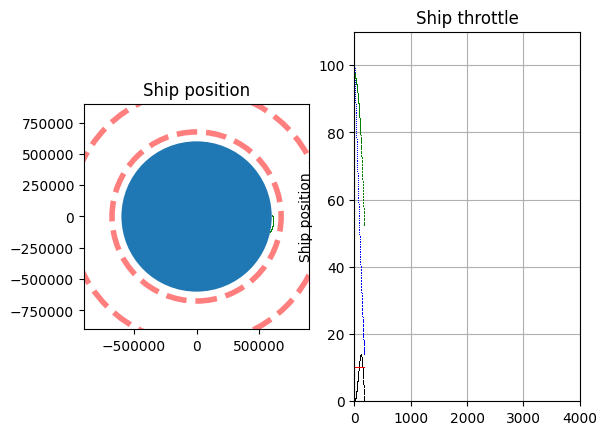

Running episode 1
INIT Kerbin position: [0. 0.]
First altitude: 600002.9306781292
First observation: [3.90757084e-05 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.9762845 0.975804 ]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       3, rewards:   0.00, throttle: 97.6, angle: -0.00, fuel: 336000.0 LOSS: 4671.32958984375 
Time:  25, altitude:    1214, rewards:   0.25, throttle: 95.5, angle: -0.41, fuel: 286786.9 LOSS: 4466.28076171875 
Time:  50, altitude:    4732, rewards:   0.50, throttle: 92.4, angle: -0.79, fuel: 238841.0 LOSS: 4184.41015625 
Time:  75, altitude:    9360, rewards:   0.75, throttle: 87.9, angle: -1.14, fuel: 192805.2 LOSS: 3787.48583984375 
Time: 100, altitude:   12963, rewards:   1.00, throttle: 81.6, angle: -1.45, fuel: 149504.4 LOSS: 3263.570556640625 

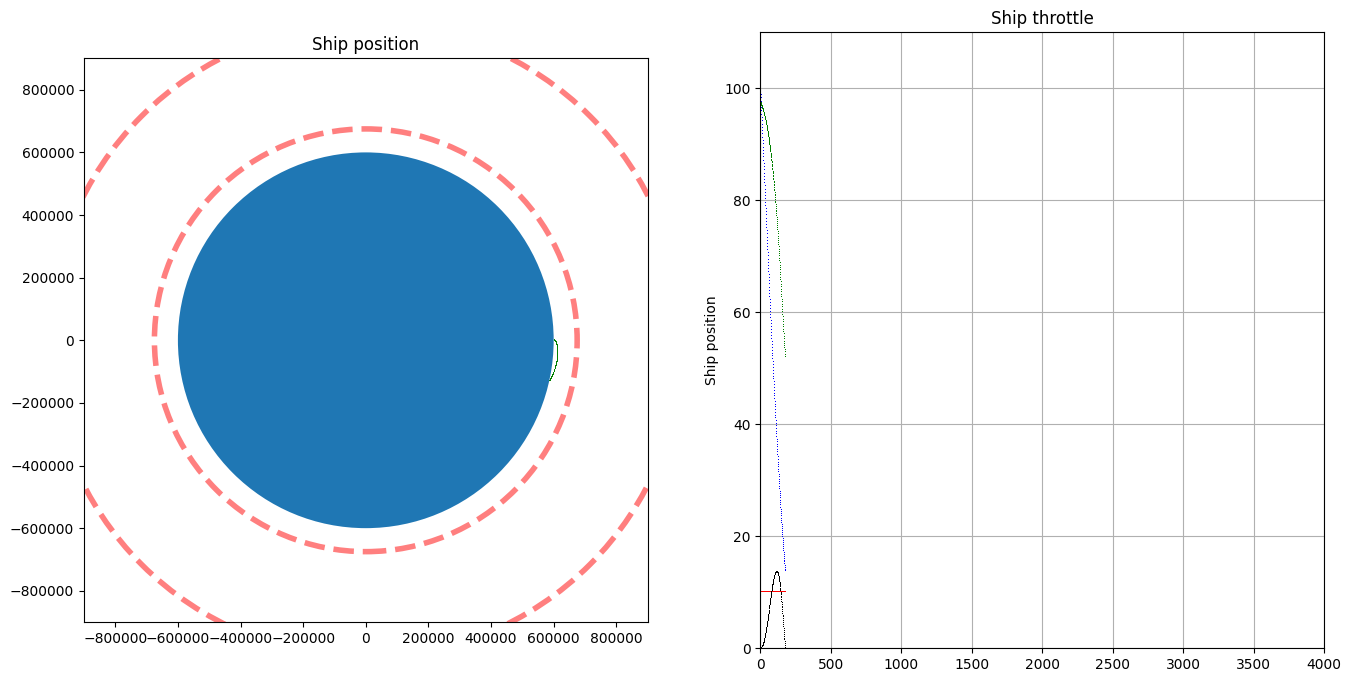


EPOCH: 1/1000, mean rewards: -249998.2487
DISCOUNTING AND NORMALIZING REWARDS


Epoch 1 INIT
INIT Kerbin position: [0. 0.]
Running episode 0
INIT Kerbin position: [0. 0.]
First altitude: 600001.4446759224
First observation: [1.92623456e-05 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.97730386 0.97677445]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       1, rewards:   0.00, throttle: 97.7, angle: -0.00, fuel: 336000.0 LOSS: 4681.091796875 
Time:  25, altitude:    1218, rewards:   0.25, throttle: 95.6, angle: -0.41, fuel: 286724.2 LOSS: 4478.94482421875 
Time:  50, altitude:    4749, rewards:   0.50, throttle: 92.5, angle: -0.79, fuel: 238707.4 LOSS: 4196.8203125 
Time:  75, altitude:    9387, rewards:   0.75, throttle: 88.0, angle: -1.14, fuel: 192611.2 LOSS: 3795.225341

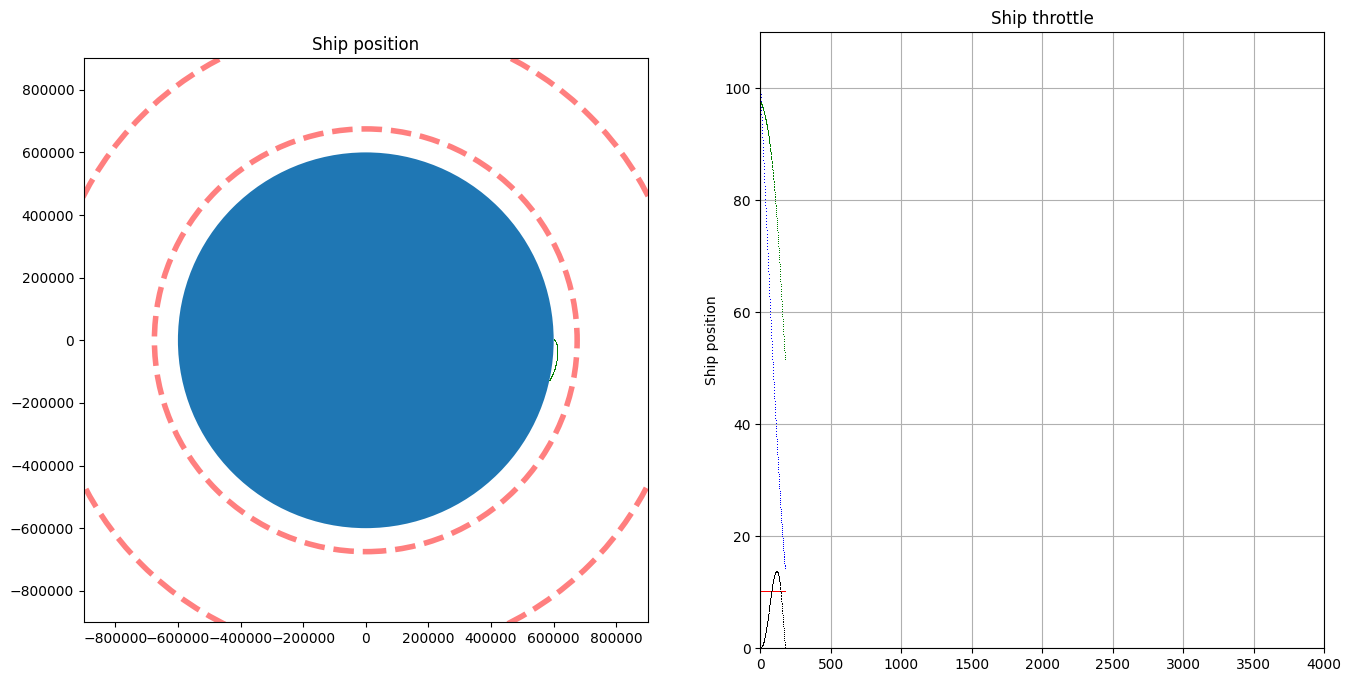

Running episode 1
INIT Kerbin position: [0. 0.]
First altitude: 600003.0282616615
First observation: [4.03768222e-05 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.9773043  0.97677493]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       3, rewards:   0.00, throttle: 97.7, angle: -0.00, fuel: 336000.0 LOSS: 4681.09619140625 
Time:  25, altitude:    1219, rewards:   0.25, throttle: 95.6, angle: -0.41, fuel: 286724.2 LOSS: 4478.95263671875 
Time:  50, altitude:    4751, rewards:   0.50, throttle: 92.5, angle: -0.79, fuel: 238707.3 LOSS: 4196.83349609375 
Time:  75, altitude:    9390, rewards:   0.75, throttle: 88.0, angle: -1.14, fuel: 192611.1 LOSS: 3795.247802734375 
Time: 100, altitude:   12984, rewards:   1.00, throttle: 81.6, angle: -1.45, fuel: 149291.1 LOSS: 3261.3701171

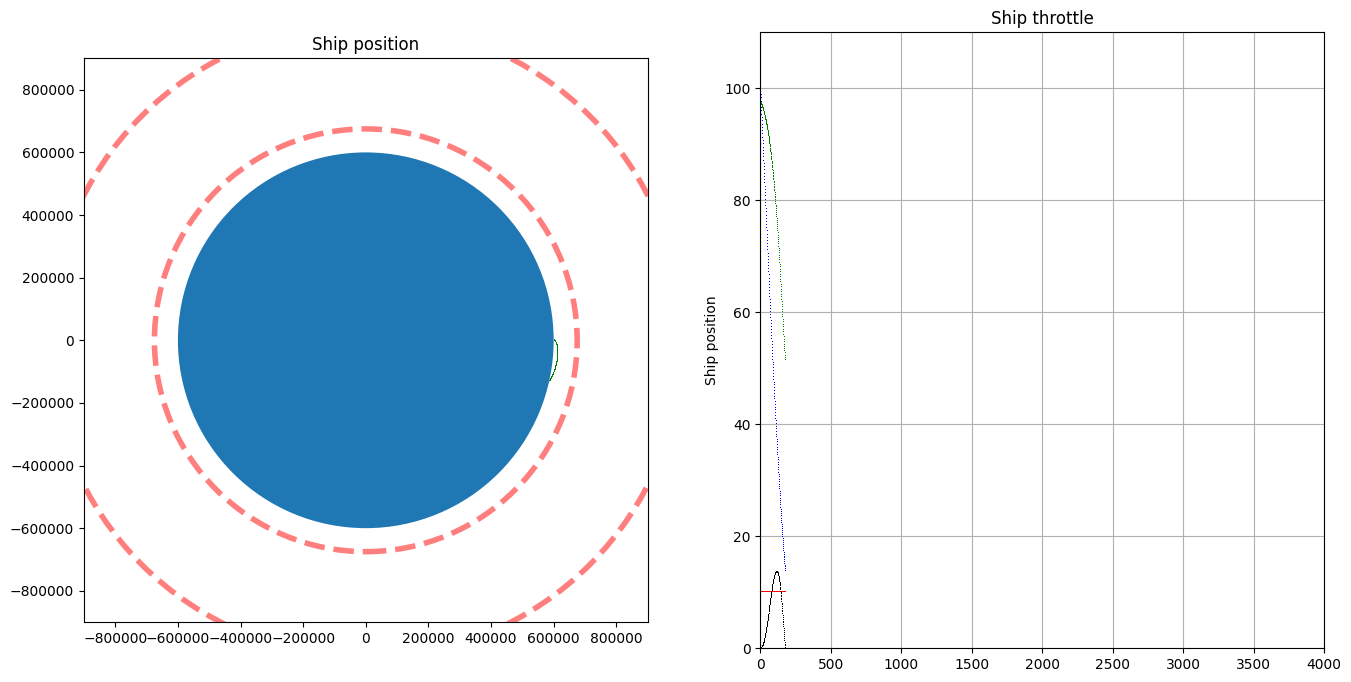


EPOCH: 2/1000, mean rewards: -249998.2498
DISCOUNTING AND NORMALIZING REWARDS


Epoch 2 INIT
INIT Kerbin position: [0. 0.]
Running episode 0
INIT Kerbin position: [0. 0.]
First altitude: 600000.3478682041
First observation: [4.63824272e-06 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.97830206 0.9777315 ]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       0, rewards:   0.00, throttle: 97.8, angle: -0.00, fuel: 336000.0 LOSS: 4690.66162109375 
Time:  25, altitude:    1222, rewards:   0.25, throttle: 95.7, angle: -0.41, fuel: 286662.0 LOSS: 4491.64404296875 
Time:  50, altitude:    4767, rewards:   0.50, throttle: 92.7, angle: -0.79, fuel: 238573.7 LOSS: 4209.46484375 
Time:  75, altitude:    9415, rewards:   0.75, throttle: 88.1, angle: -1.15, fuel: 192415.6 LOSS: 3803.278

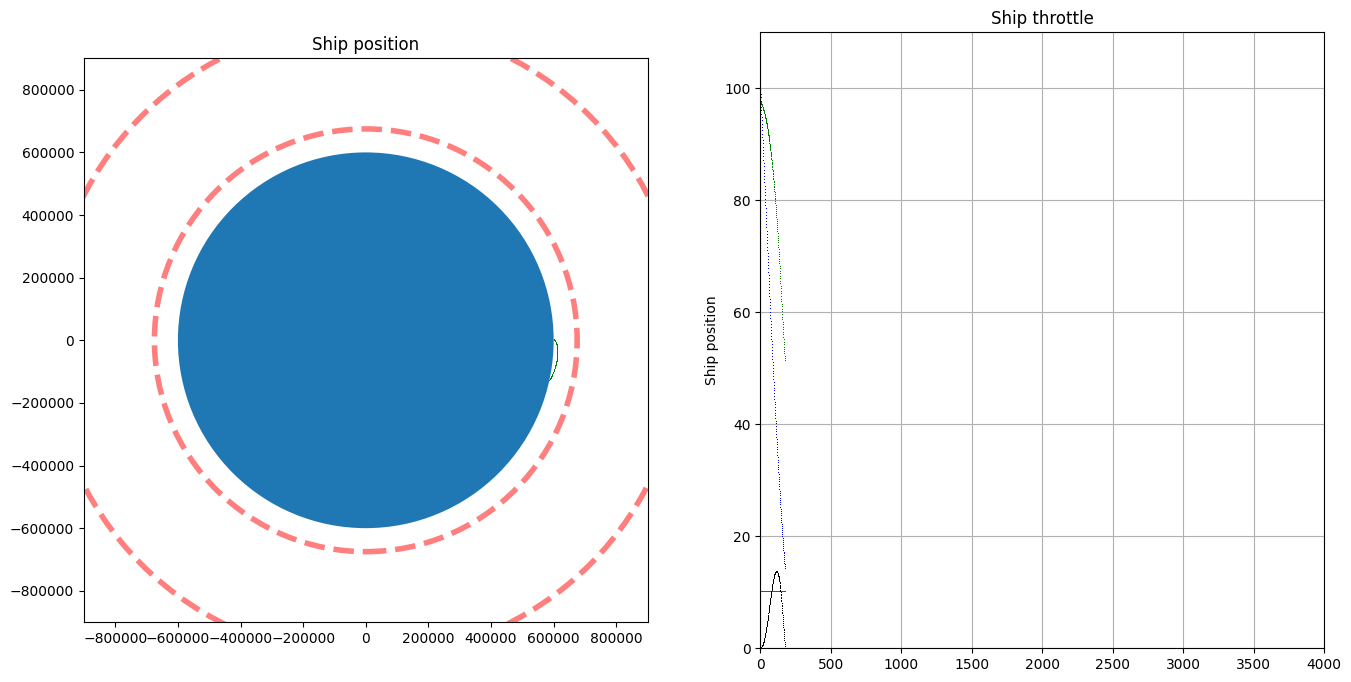

Running episode 1
INIT Kerbin position: [0. 0.]
First altitude: 600008.8265552521
First observation: [1.17687403e-04 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.9783043 0.9777338]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       9, rewards:   0.00, throttle: 97.8, angle: -0.00, fuel: 336000.0 LOSS: 4690.6826171875 
Time:  25, altitude:    1231, rewards:   0.25, throttle: 95.7, angle: -0.41, fuel: 286661.9 LOSS: 4491.68212890625 
Time:  50, altitude:    4777, rewards:   0.50, throttle: 92.7, angle: -0.79, fuel: 238573.2 LOSS: 4209.53515625 
Time:  75, altitude:    9428, rewards:   0.75, throttle: 88.1, angle: -1.15, fuel: 192414.6 LOSS: 3803.4013671875 
Time: 100, altitude:   13015, rewards:   1.00, throttle: 81.6, angle: -1.45, fuel: 149073.3 LOSS: 3259.453125 
Time: 1

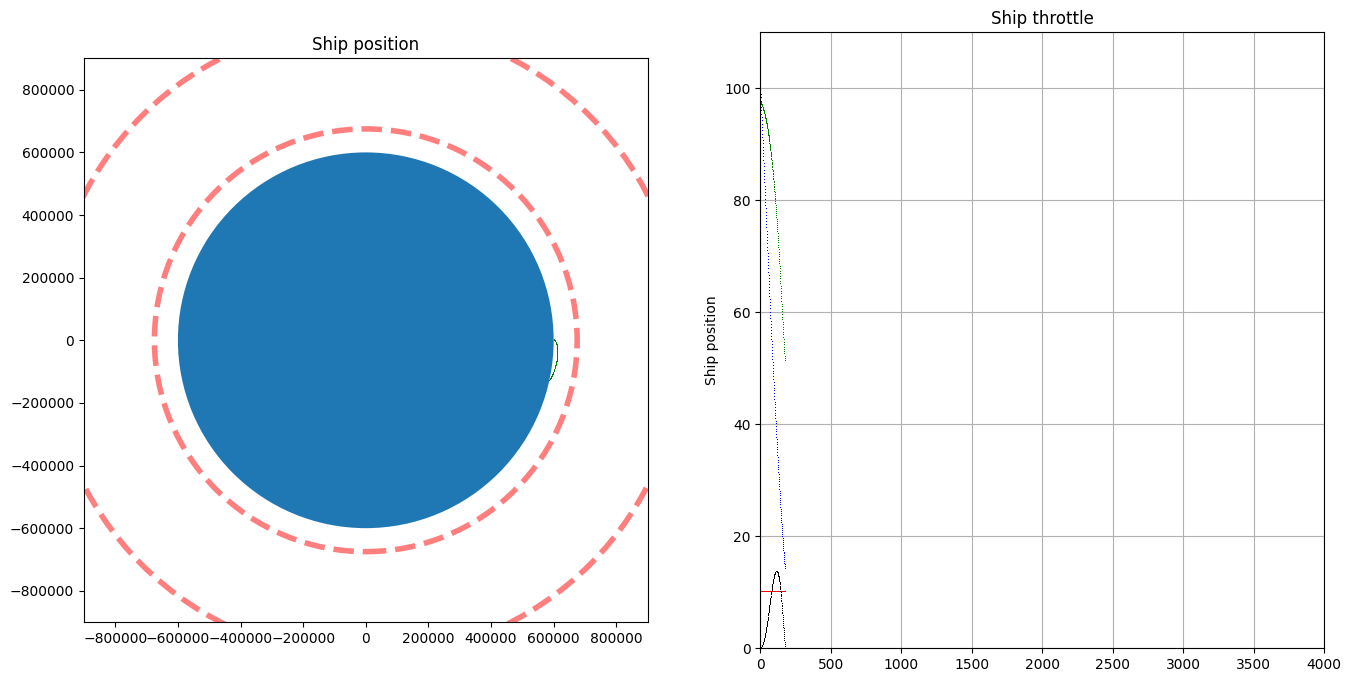


EPOCH: 3/1000, mean rewards: -249998.2508
DISCOUNTING AND NORMALIZING REWARDS


Epoch 3 INIT
INIT Kerbin position: [0. 0.]
Running episode 0
INIT Kerbin position: [0. 0.]
First altitude: 600001.7534053326
First observation: [2.33787378e-05 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.9792769 0.9786671]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       2, rewards:   0.00, throttle: 97.9, angle: -0.00, fuel: 336000.0 LOSS: 4700.01513671875 
Time:  25, altitude:    1228, rewards:   0.25, throttle: 95.9, angle: -0.41, fuel: 286601.0 LOSS: 4504.220703125 
Time:  50, altitude:    4787, rewards:   0.50, throttle: 92.8, angle: -0.80, fuel: 238441.5 LOSS: 4222.14794921875 
Time:  75, altitude:    9446, rewards:   0.75, throttle: 88.2, angle: -1.15, fuel: 192221.0 LOSS: 3811.4396

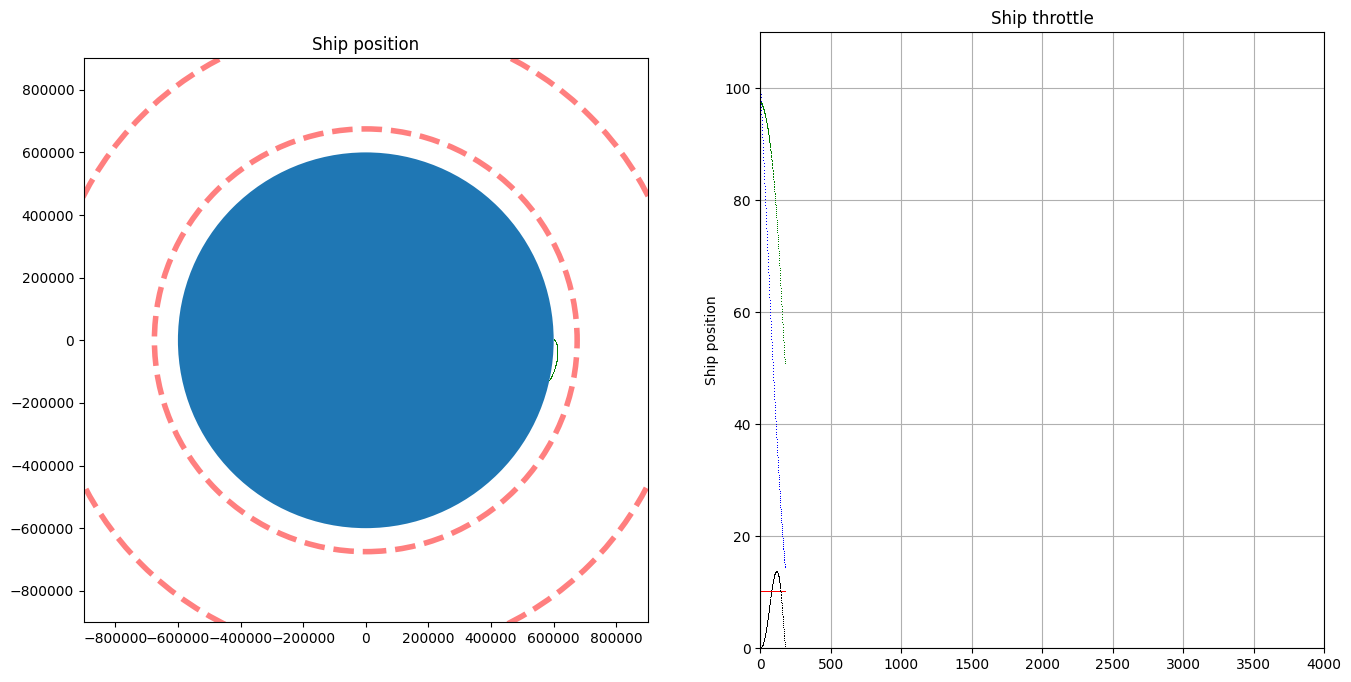

Running episode 1
INIT Kerbin position: [0. 0.]
First altitude: 600001.8242478371
First observation: [2.43233045e-05 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.9792769 0.9786671]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       2, rewards:   0.00, throttle: 97.9, angle: -0.00, fuel: 336000.0 LOSS: 4700.01513671875 
Time:  25, altitude:    1228, rewards:   0.25, throttle: 95.9, angle: -0.41, fuel: 286601.0 LOSS: 4504.22119140625 
Time:  50, altitude:    4787, rewards:   0.50, throttle: 92.8, angle: -0.80, fuel: 238441.5 LOSS: 4222.14794921875 
Time:  75, altitude:    9446, rewards:   0.75, throttle: 88.2, angle: -1.15, fuel: 192221.0 LOSS: 3811.440185546875 
Time: 100, altitude:   13021, rewards:   1.00, throttle: 81.5, angle: -1.46, fuel: 148859.8 LOSS: 3257.164794921

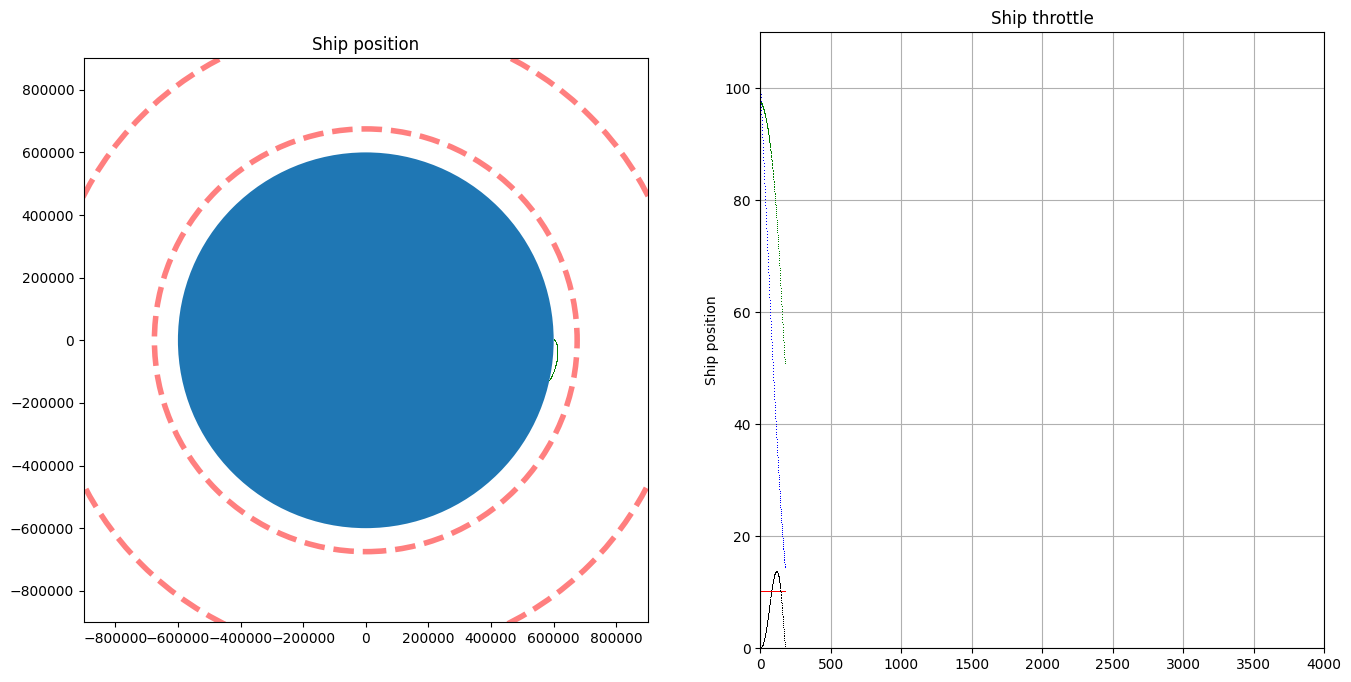


EPOCH: 4/1000, mean rewards: -249998.2522
DISCOUNTING AND NORMALIZING REWARDS


Epoch 4 INIT
INIT Kerbin position: [0. 0.]
Running episode 0
INIT Kerbin position: [0. 0.]
First altitude: 600000.0961744785
First observation: [1.28232638e-06 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.9802179 0.9795738]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       0, rewards:   0.00, throttle: 98.0, angle: -0.00, fuel: 336000.0 LOSS: 4709.05419921875 
Time:  25, altitude:    1231, rewards:   0.25, throttle: 96.0, angle: -0.41, fuel: 286541.9 LOSS: 4516.4990234375 
Time:  50, altitude:    4802, rewards:   0.50, throttle: 93.0, angle: -0.80, fuel: 238312.6 LOSS: 4234.62060546875 
Time:  75, altitude:    9472, rewards:   0.75, throttle: 88.3, angle: -1.15, fuel: 192031.0 LOSS: 3819.388

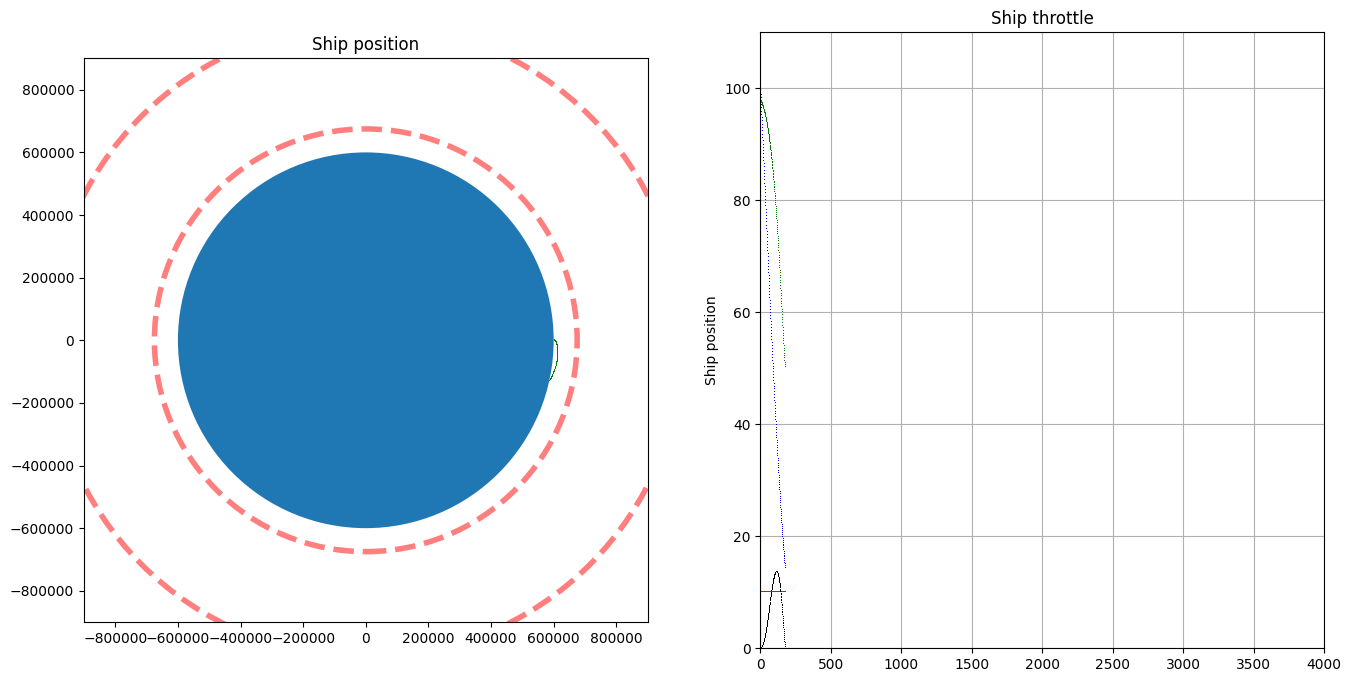

Running episode 1
INIT Kerbin position: [0. 0.]
First altitude: 600006.7948570251
First observation: [9.05980937e-05 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.9802196  0.97957546]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       7, rewards:   0.00, throttle: 98.0, angle: -0.00, fuel: 336000.0 LOSS: 4709.07080078125 
Time:  25, altitude:    1238, rewards:   0.25, throttle: 96.0, angle: -0.41, fuel: 286541.7 LOSS: 4516.52880859375 
Time:  50, altitude:    4810, rewards:   0.50, throttle: 93.0, angle: -0.80, fuel: 238312.3 LOSS: 4234.67578125 
Time:  75, altitude:    9482, rewards:   0.75, throttle: 88.3, angle: -1.15, fuel: 192030.2 LOSS: 3819.48681640625 
Time: 100, altitude:   13048, rewards:   1.00, throttle: 81.5, angle: -1.46, fuel: 148649.1 LOSS: 3254.83520507812

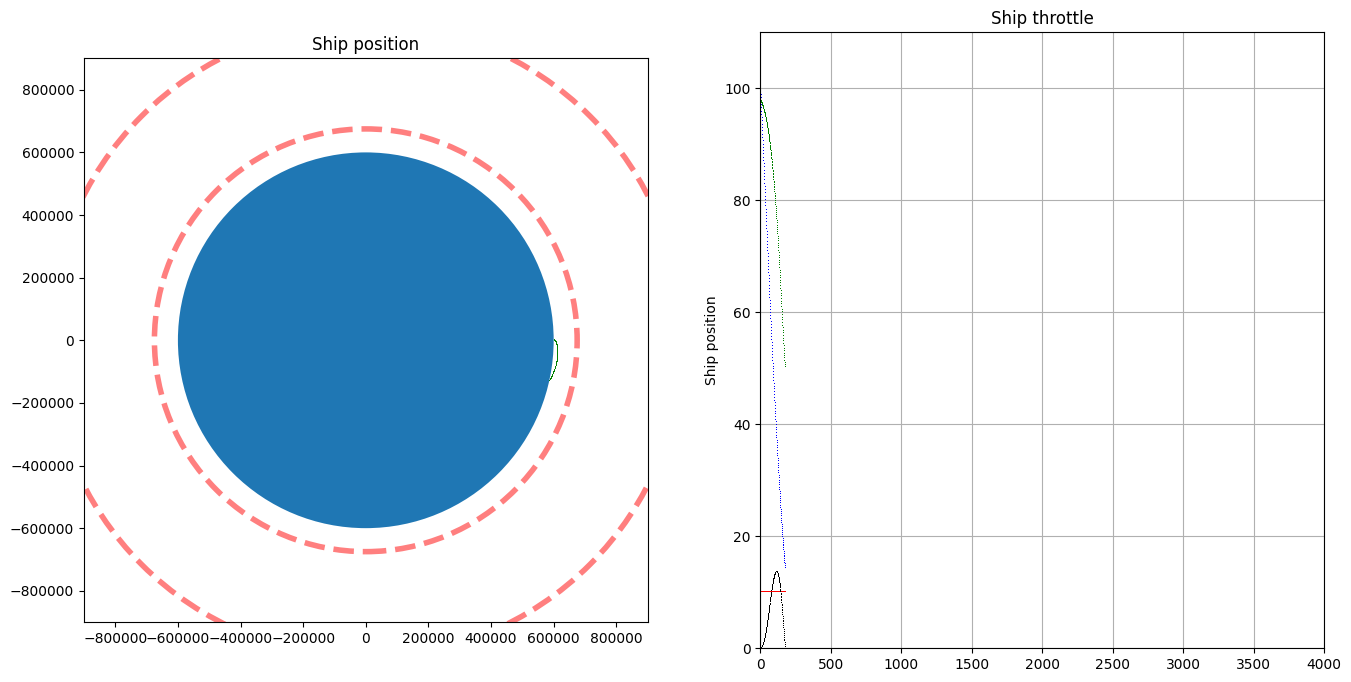


EPOCH: 5/1000, mean rewards: -249998.2532
DISCOUNTING AND NORMALIZING REWARDS


Epoch 5 INIT
INIT Kerbin position: [0. 0.]
Running episode 0
INIT Kerbin position: [0. 0.]
First altitude: 600004.3445863724
First observation: [5.79278183e-05 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.98111266 0.98044276]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       4, rewards:   0.00, throttle: 98.1, angle: -0.00, fuel: 336000.0 LOSS: 4717.65625 
Time:  25, altitude:    1240, rewards:   0.25, throttle: 96.1, angle: -0.41, fuel: 286484.9 LOSS: 4528.40478515625 
Time:  50, altitude:    4824, rewards:   0.50, throttle: 93.1, angle: -0.80, fuel: 238187.9 LOSS: 4246.79541015625 
Time:  75, altitude:    9505, rewards:   0.75, throttle: 88.4, angle: -1.16, fuel: 191846.8 LOSS: 3827.060058

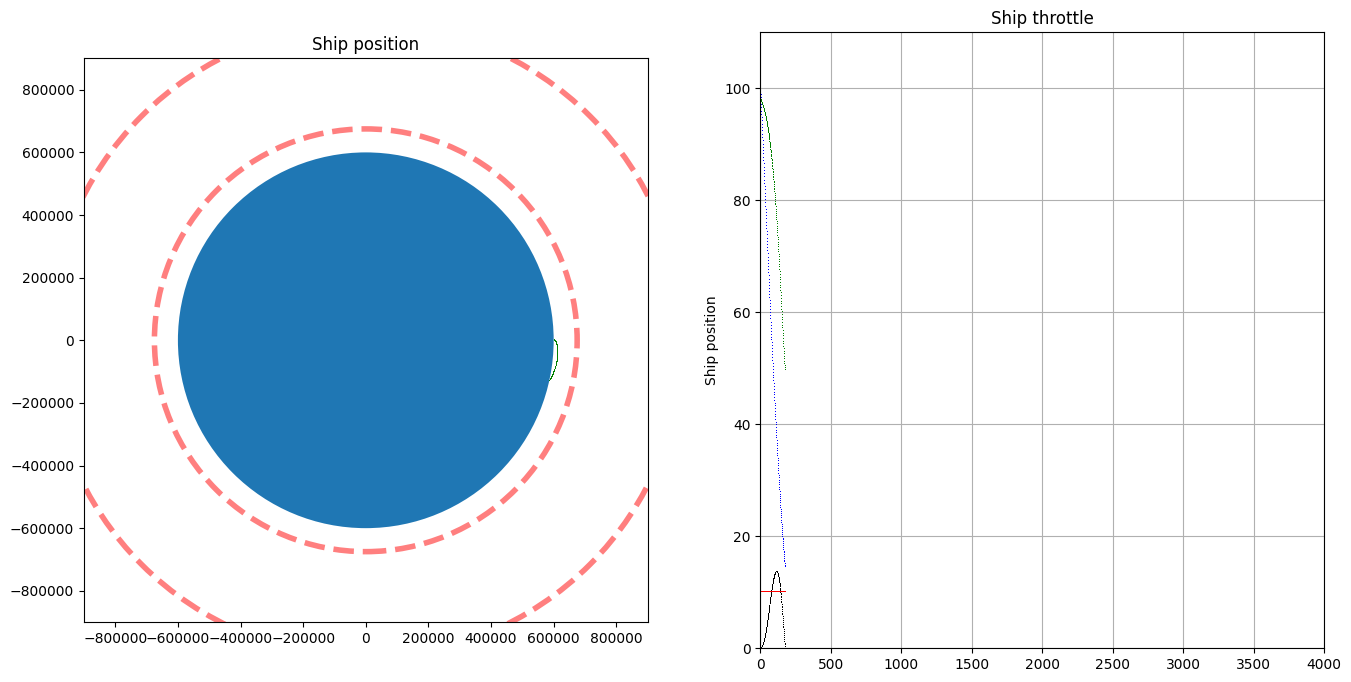

Running episode 1
INIT Kerbin position: [0. 0.]
First altitude: 600001.3617551327
First observation: [1.81567351e-05 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.98111194 0.980442  ]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       1, rewards:   0.00, throttle: 98.1, angle: -0.00, fuel: 336000.0 LOSS: 4717.6494140625 
Time:  25, altitude:    1237, rewards:   0.25, throttle: 96.1, angle: -0.41, fuel: 286485.0 LOSS: 4528.392578125 
Time:  50, altitude:    4821, rewards:   0.50, throttle: 93.1, angle: -0.80, fuel: 238188.0 LOSS: 4246.771484375 
Time:  75, altitude:    9500, rewards:   0.75, throttle: 88.4, angle: -1.16, fuel: 191847.1 LOSS: 3827.016357421875 
Time: 100, altitude:   13055, rewards:   1.00, throttle: 81.5, angle: -1.46, fuel: 148450.0 LOSS: 3251.74658203125 

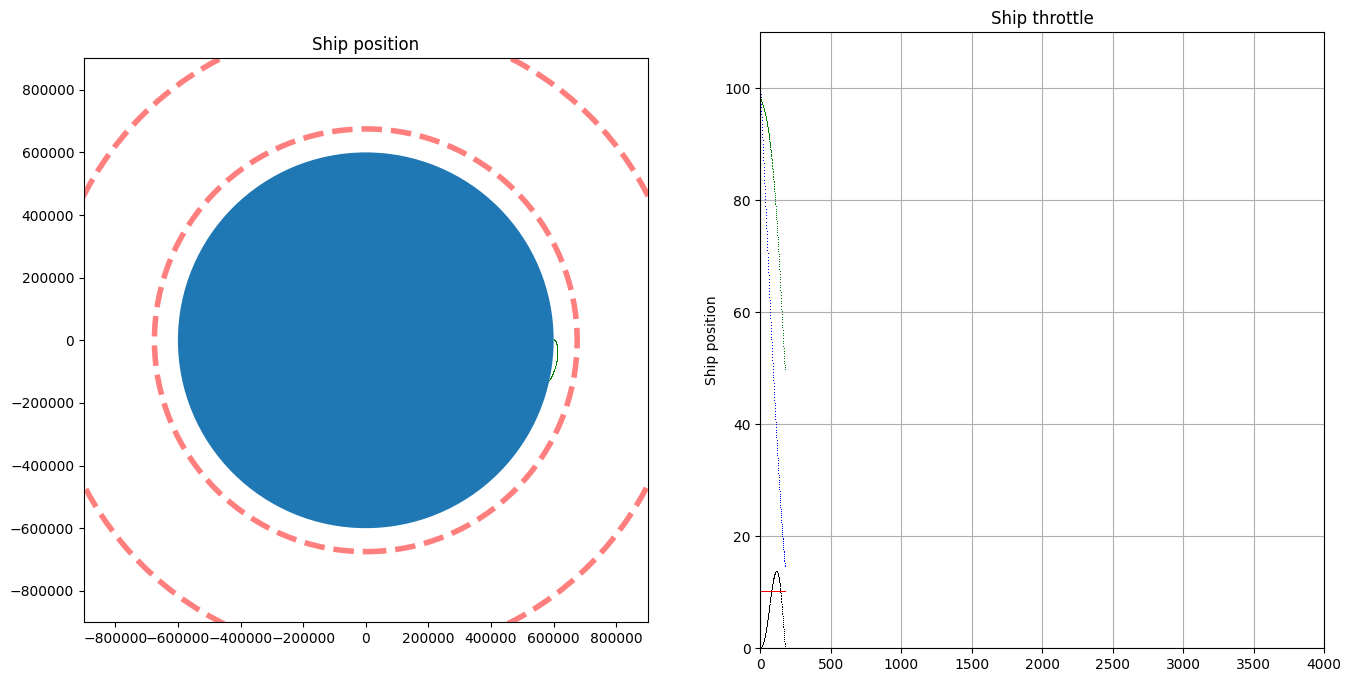


EPOCH: 6/1000, mean rewards: -249998.2541
DISCOUNTING AND NORMALIZING REWARDS


Epoch 6 INIT
INIT Kerbin position: [0. 0.]
Running episode 0
INIT Kerbin position: [0. 0.]
First altitude: 600006.8207273483
First observation: [9.09430313e-05 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.981961  0.9812722]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       7, rewards:   0.00, throttle: 98.2, angle: -0.00, fuel: 336000.0 LOSS: 4725.81884765625 
Time:  25, altitude:    1247, rewards:   0.25, throttle: 96.2, angle: -0.41, fuel: 286430.6 LOSS: 4539.8134765625 
Time:  50, altitude:    4844, rewards:   0.50, throttle: 93.2, angle: -0.80, fuel: 238068.6 LOSS: 4258.47265625 
Time:  75, altitude:    9534, rewards:   0.75, throttle: 88.4, angle: -1.16, fuel: 191671.1 LOSS: 3834.170410

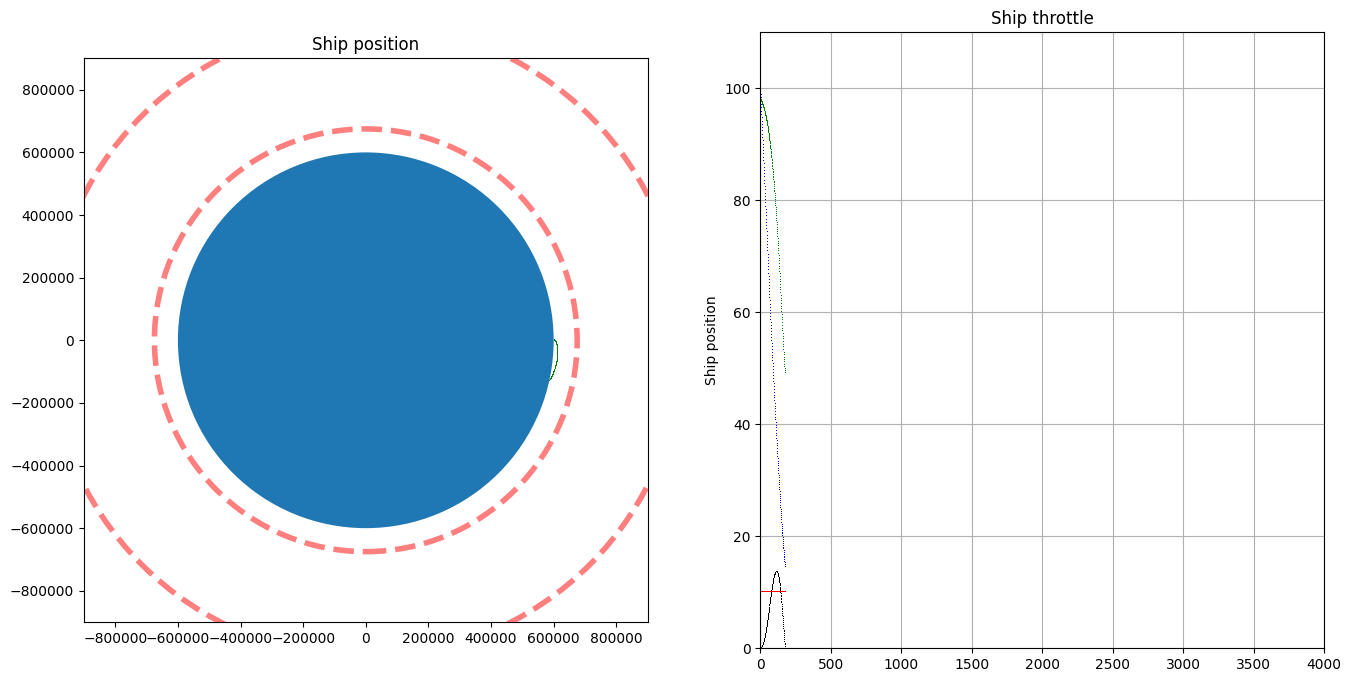

Running episode 1
INIT Kerbin position: [0. 0.]
First altitude: 600006.9927954674
First observation: [9.32372729e-05 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.9819611 0.9812723]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       7, rewards:   0.00, throttle: 98.2, angle: -0.00, fuel: 336000.0 LOSS: 4725.81982421875 
Time:  25, altitude:    1247, rewards:   0.25, throttle: 96.2, angle: -0.41, fuel: 286430.6 LOSS: 4539.814453125 
Time:  50, altitude:    4844, rewards:   0.50, throttle: 93.2, angle: -0.80, fuel: 238068.6 LOSS: 4258.47412109375 
Time:  75, altitude:    9534, rewards:   0.75, throttle: 88.4, angle: -1.16, fuel: 191671.1 LOSS: 3834.1728515625 
Time: 100, altitude:   13080, rewards:   1.00, throttle: 81.4, angle: -1.47, fuel: 148260.4 LOSS: 3248.23095703125 


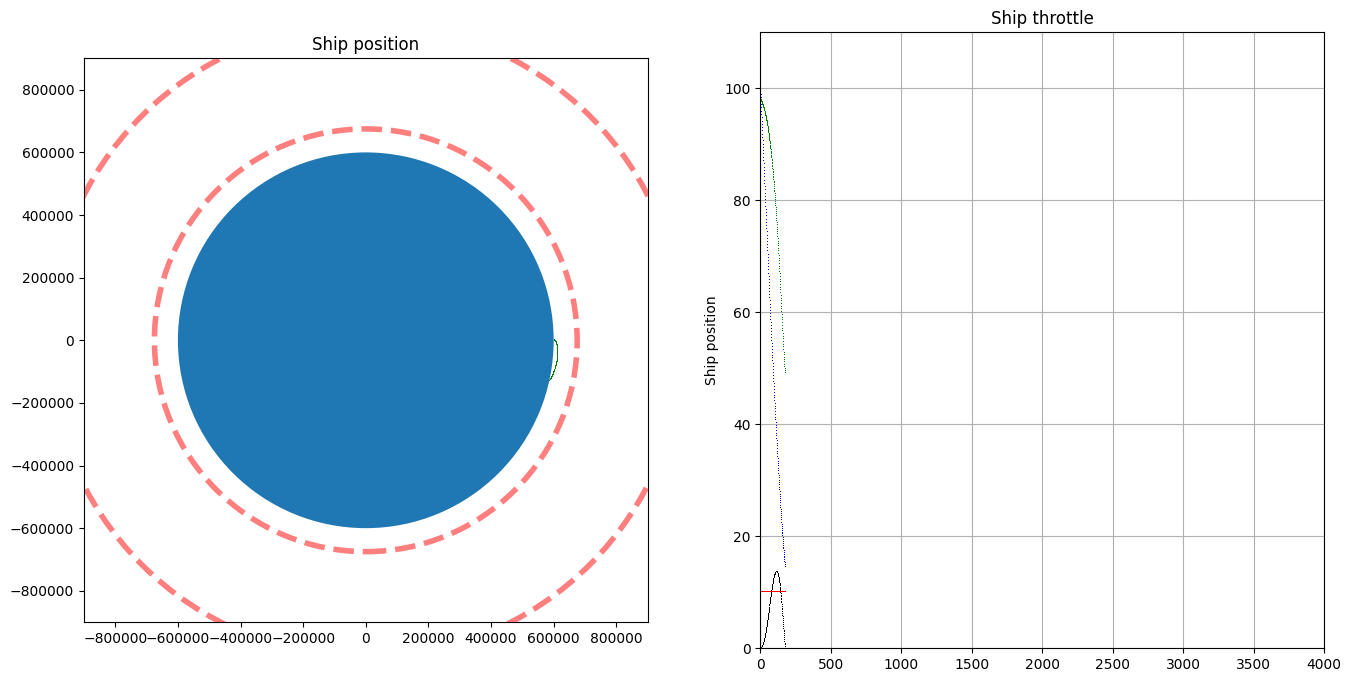


EPOCH: 7/1000, mean rewards: -249998.2545
DISCOUNTING AND NORMALIZING REWARDS


Epoch 7 INIT
INIT Kerbin position: [0. 0.]
Running episode 0
INIT Kerbin position: [0. 0.]
First altitude: 600005.6403484344
First observation: [7.52046458e-05 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.98276085 0.9820613 ]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       6, rewards:   0.00, throttle: 98.3, angle: -0.00, fuel: 336000.0 LOSS: 4733.521484375 
Time:  25, altitude:    1250, rewards:   0.25, throttle: 96.4, angle: -0.41, fuel: 286379.1 LOSS: 4550.6650390625 
Time:  50, altitude:    4858, rewards:   0.50, throttle: 93.3, angle: -0.80, fuel: 237955.4 LOSS: 4269.54833984375 
Time:  75, altitude:    9556, rewards:   0.75, throttle: 88.5, angle: -1.16, fuel: 191505.2 LOSS: 3840.569

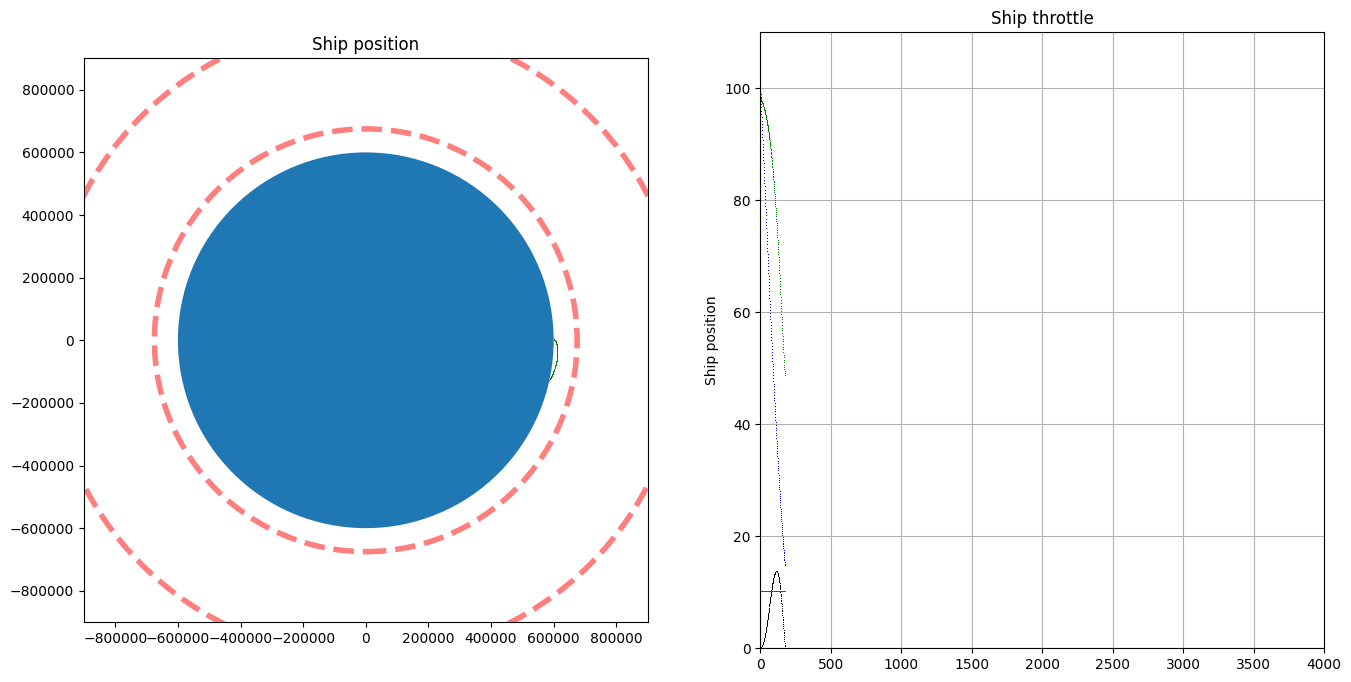

Running episode 1
INIT Kerbin position: [0. 0.]
First altitude: 600007.3486661911
First observation: [9.79822159e-05 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.98276126 0.98206174]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       7, rewards:   0.00, throttle: 98.3, angle: -0.00, fuel: 336000.0 LOSS: 4733.525390625 
Time:  25, altitude:    1252, rewards:   0.25, throttle: 96.4, angle: -0.41, fuel: 286379.1 LOSS: 4550.671875 
Time:  50, altitude:    4860, rewards:   0.50, throttle: 93.3, angle: -0.80, fuel: 237955.3 LOSS: 4269.5625 
Time:  75, altitude:    9558, rewards:   0.75, throttle: 88.5, angle: -1.16, fuel: 191505.0 LOSS: 3840.595947265625 
Time: 100, altitude:   13095, rewards:   1.00, throttle: 81.4, angle: -1.47, fuel: 148085.9 LOSS: 3243.77587890625 
Time: 12

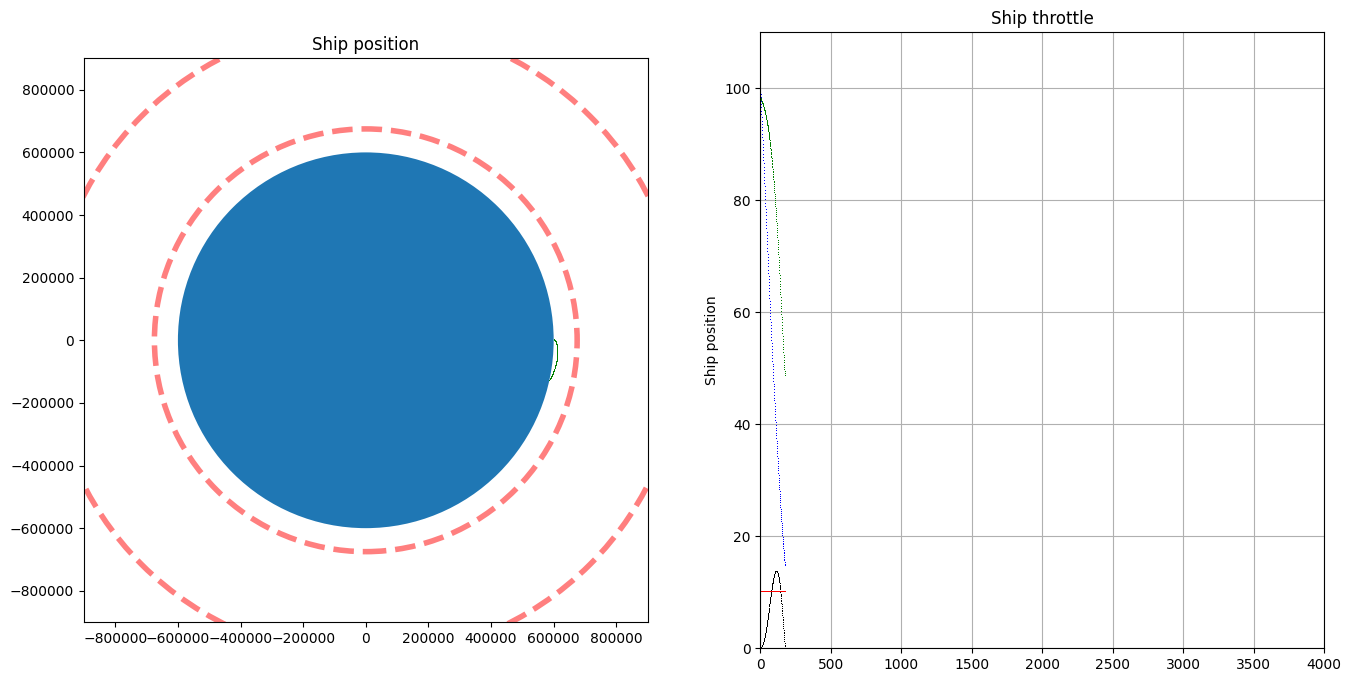


EPOCH: 8/1000, mean rewards: -249998.2551
DISCOUNTING AND NORMALIZING REWARDS


Epoch 8 INIT
INIT Kerbin position: [0. 0.]
Running episode 0
INIT Kerbin position: [0. 0.]
First altitude: 600001.3681411743
First observation: [1.82418823e-05 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.9835159  0.98281085]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       1, rewards:   0.00, throttle: 98.4, angle: -0.00, fuel: 336000.0 LOSS: 4740.79833984375 
Time:  25, altitude:    1249, rewards:   0.25, throttle: 96.5, angle: -0.41, fuel: 286330.5 LOSS: 4560.9267578125 
Time:  50, altitude:    4867, rewards:   0.50, throttle: 93.4, angle: -0.81, fuel: 237848.6 LOSS: 4279.9560546875 
Time:  75, altitude:    9572, rewards:   0.75, throttle: 88.6, angle: -1.16, fuel: 191349.9 LOSS: 3846.16

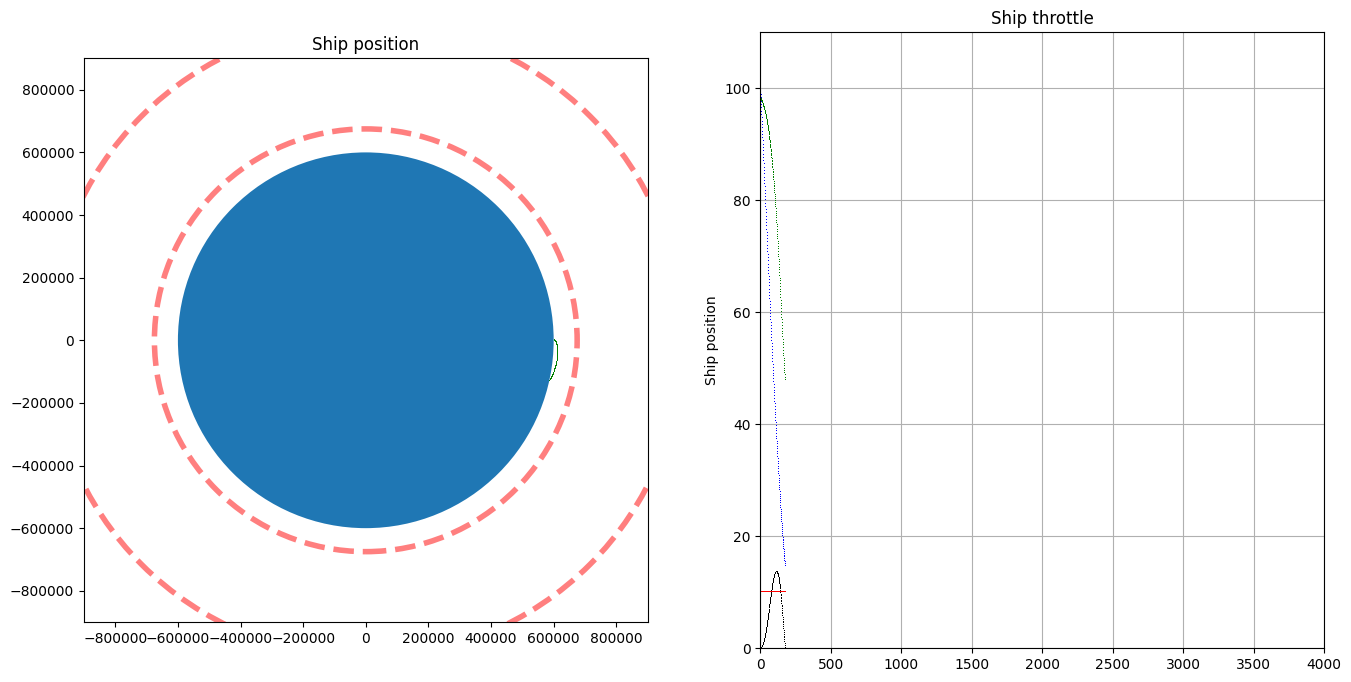

Running episode 1
INIT Kerbin position: [0. 0.]
First altitude: 600001.8242573738
First observation: [2.43234317e-05 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.983516 0.982811]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       2, rewards:   0.00, throttle: 98.4, angle: -0.00, fuel: 336000.0 LOSS: 4740.79931640625 
Time:  25, altitude:    1250, rewards:   0.25, throttle: 96.5, angle: -0.41, fuel: 286330.5 LOSS: 4560.927734375 
Time:  50, altitude:    4867, rewards:   0.50, throttle: 93.4, angle: -0.81, fuel: 237848.5 LOSS: 4279.9599609375 
Time:  75, altitude:    9572, rewards:   0.75, throttle: 88.6, angle: -1.16, fuel: 191349.9 LOSS: 3846.17138671875 
Time: 100, altitude:   13096, rewards:   1.00, throttle: 81.3, angle: -1.47, fuel: 147928.2 LOSS: 3238.25341796875 
Ti

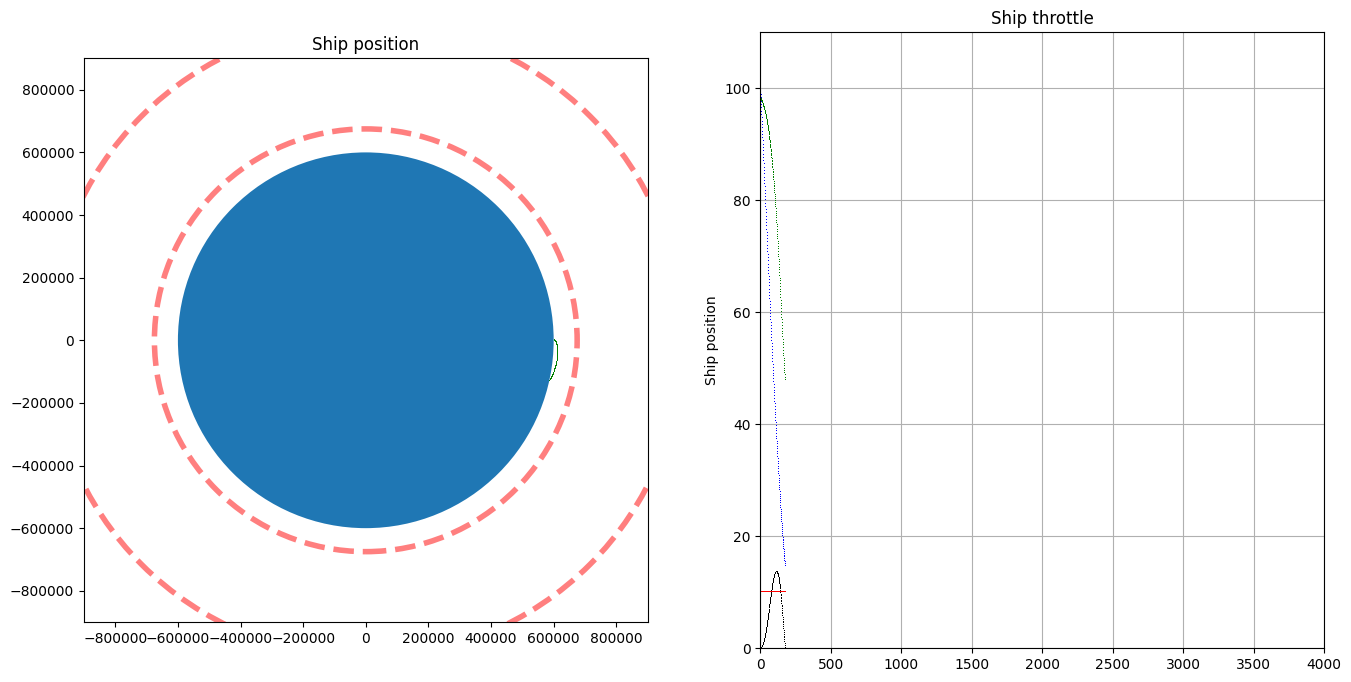


EPOCH: 9/1000, mean rewards: -249998.2556
DISCOUNTING AND NORMALIZING REWARDS


Epoch 9 INIT
INIT Kerbin position: [0. 0.]
Running episode 0
INIT Kerbin position: [0. 0.]
First altitude: 600004.5021209717
First observation: [6.00282796e-05 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.9842292  0.98352337]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       5, rewards:   0.00, throttle: 98.4, angle: -0.00, fuel: 336000.0 LOSS: 4747.67724609375 
Time:  25, altitude:    1256, rewards:   0.25, throttle: 96.6, angle: -0.41, fuel: 286284.6 LOSS: 4570.6259765625 
Time:  50, altitude:    4884, rewards:   0.50, throttle: 93.6, angle: -0.81, fuel: 237747.8 LOSS: 4289.740234375 
Time:  75, altitude:    9597, rewards:   0.75, throttle: 88.6, angle: -1.17, fuel: 191204.6 LOSS: 3851.048

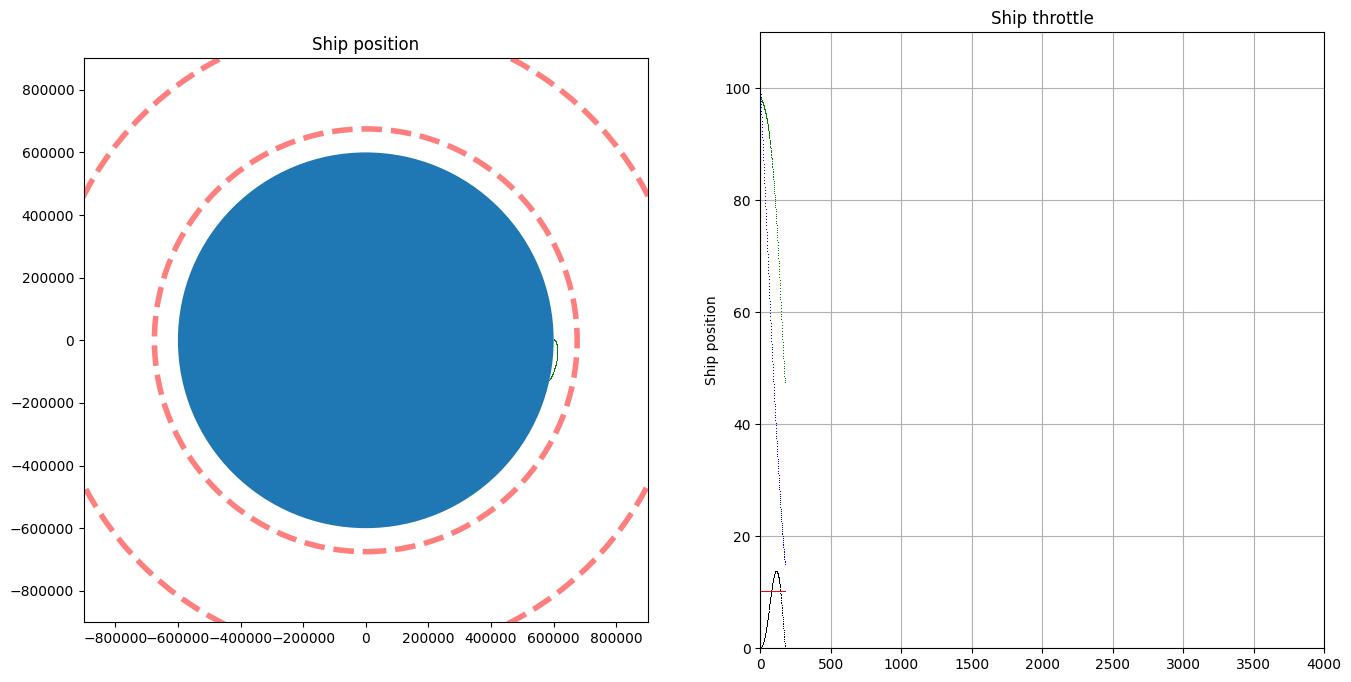

Running episode 1
INIT Kerbin position: [0. 0.]
First altitude: 600001.1717963219
First observation: [1.56239510e-05 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.9842285 0.9835226]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       1, rewards:   0.00, throttle: 98.4, angle: -0.00, fuel: 336000.0 LOSS: 4747.67041015625 
Time:  25, altitude:    1253, rewards:   0.25, throttle: 96.6, angle: -0.41, fuel: 286284.7 LOSS: 4570.611328125 
Time:  50, altitude:    4880, rewards:   0.50, throttle: 93.6, angle: -0.81, fuel: 237747.9 LOSS: 4289.712890625 
Time:  75, altitude:    9592, rewards:   0.75, throttle: 88.6, angle: -1.17, fuel: 191204.9 LOSS: 3850.9970703125 
Time: 100, altitude:   13105, rewards:   1.00, throttle: 81.2, angle: -1.47, fuel: 147785.7 LOSS: 3231.85400390625 
Ti

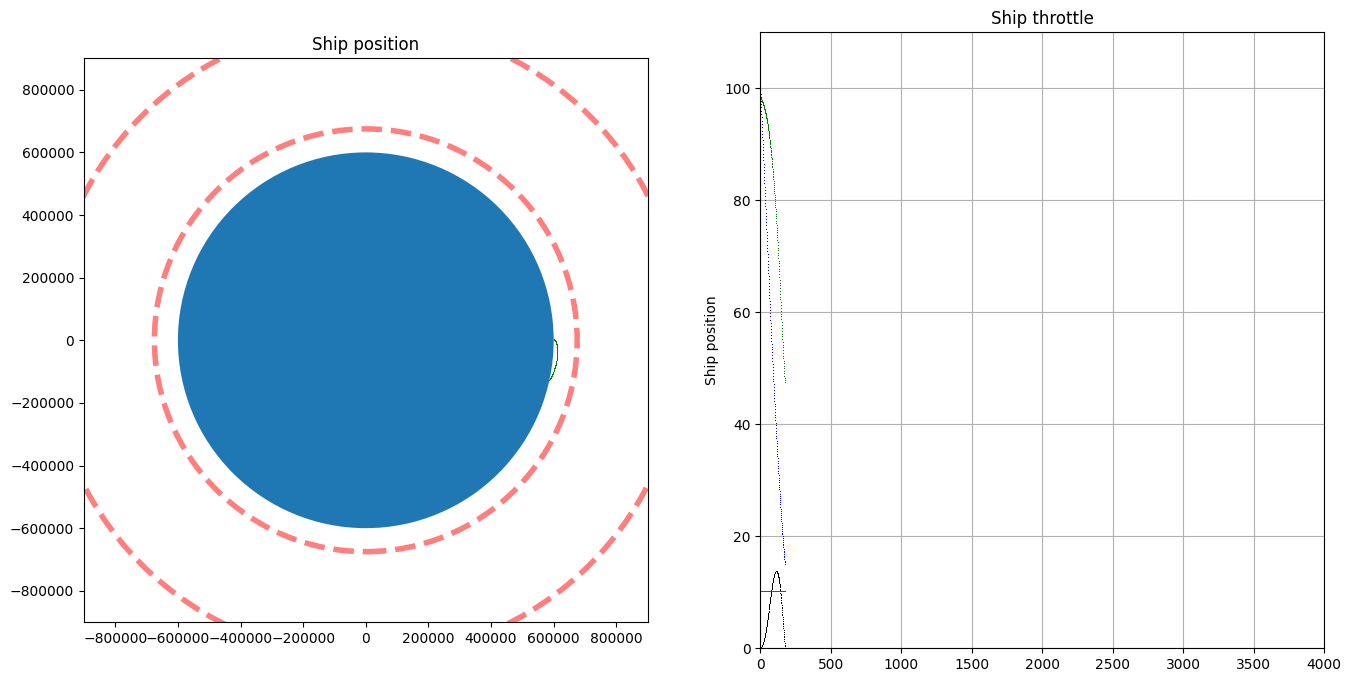


EPOCH: 10/1000, mean rewards: -249998.2553
DISCOUNTING AND NORMALIZING REWARDS


Epoch 10 INIT
INIT Kerbin position: [0. 0.]
Running episode 0
INIT Kerbin position: [0. 0.]
First altitude: 600009.4130306244
First observation: [1.25507075e-04 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.9849009  0.98419946]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       9, rewards:   0.00, throttle: 98.5, angle: -0.00, fuel: 336000.0 LOSS: 4754.1591796875 
Time:  25, altitude:    1265, rewards:   0.25, throttle: 96.7, angle: -0.41, fuel: 286241.4 LOSS: 4579.7666015625 
Time:  50, altitude:    4903, rewards:   0.50, throttle: 93.7, angle: -0.81, fuel: 237653.0 LOSS: 4298.8740234375 
Time:  75, altitude:    9623, rewards:   0.75, throttle: 88.7, angle: -1.17, fuel: 191069.3 LOSS: 3855.1

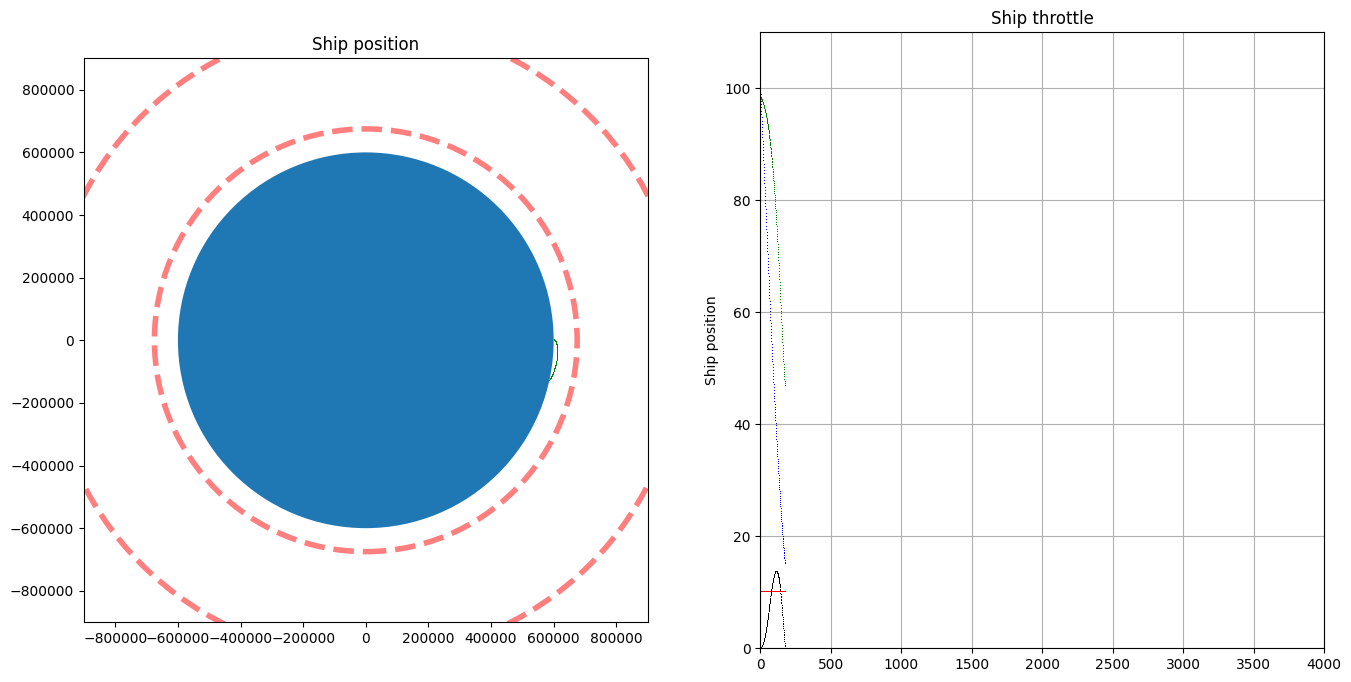

Running episode 1
INIT Kerbin position: [0. 0.]
First altitude: 600004.3923950195
First observation: [5.85652669e-05 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.9848998  0.98419833]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       4, rewards:   0.00, throttle: 98.5, angle: -0.00, fuel: 336000.0 LOSS: 4754.14892578125 
Time:  25, altitude:    1260, rewards:   0.25, throttle: 96.7, angle: -0.41, fuel: 286241.5 LOSS: 4579.74609375 
Time:  50, altitude:    4897, rewards:   0.50, throttle: 93.7, angle: -0.81, fuel: 237653.3 LOSS: 4298.8310546875 
Time:  75, altitude:    9616, rewards:   0.75, throttle: 88.7, angle: -1.17, fuel: 191069.9 LOSS: 3855.064453125 
Time: 100, altitude:   13121, rewards:   1.00, throttle: 81.1, angle: -1.48, fuel: 147658.1 LOSS: 3224.563232421875 


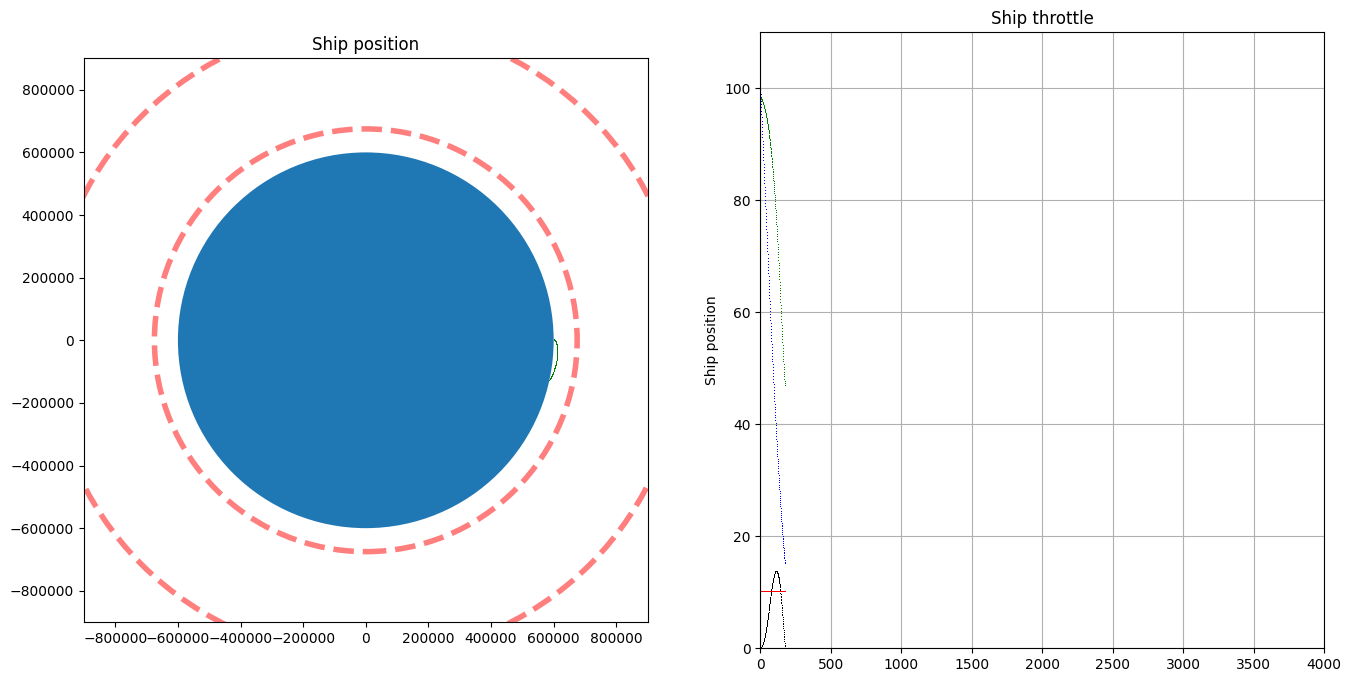


EPOCH: 11/1000, mean rewards: -249998.2546
DISCOUNTING AND NORMALIZING REWARDS


Epoch 11 INIT
INIT Kerbin position: [0. 0.]
Running episode 0
INIT Kerbin position: [0. 0.]
First altitude: 600007.5304470062
First observation: [1.00405960e-04 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.9855308 0.9848406]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       8, rewards:   0.00, throttle: 98.6, angle: -0.00, fuel: 336000.0 LOSS: 4760.2421875 
Time:  25, altitude:    1266, rewards:   0.25, throttle: 96.8, angle: -0.42, fuel: 286200.7 LOSS: 4588.37109375 
Time:  50, altitude:    4913, rewards:   0.50, throttle: 93.7, angle: -0.81, fuel: 237564.1 LOSS: 4307.35107421875 
Time:  75, altitude:    9638, rewards:   0.75, throttle: 88.7, angle: -1.17, fuel: 190944.1 LOSS: 3858.3818359

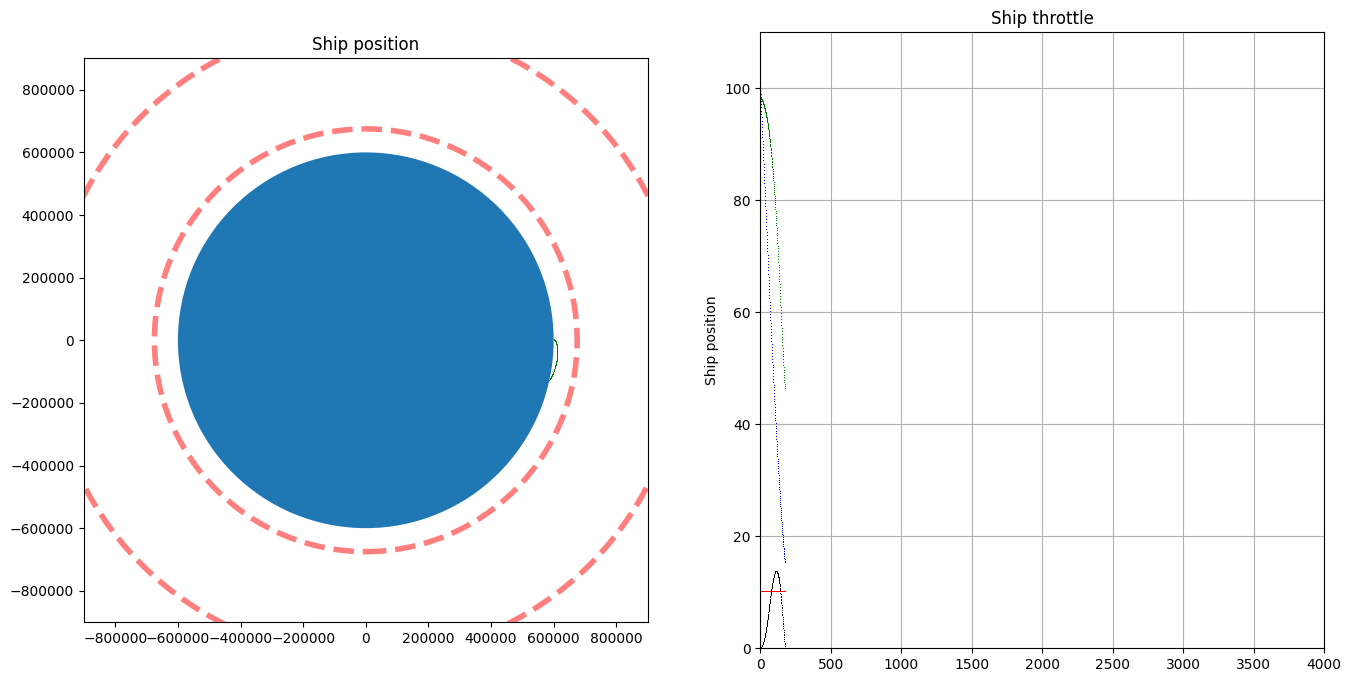

Running episode 1
INIT Kerbin position: [0. 0.]
First altitude: 600009.4828119278
First observation: [1.26437492e-04 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.9855312 0.984841 ]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       9, rewards:   0.00, throttle: 98.6, angle: -0.00, fuel: 336000.0 LOSS: 4760.24609375 
Time:  25, altitude:    1268, rewards:   0.25, throttle: 96.8, angle: -0.42, fuel: 286200.7 LOSS: 4588.3798828125 
Time:  50, altitude:    4915, rewards:   0.50, throttle: 93.7, angle: -0.81, fuel: 237564.0 LOSS: 4307.3681640625 
Time:  75, altitude:    9641, rewards:   0.75, throttle: 88.7, angle: -1.17, fuel: 190943.9 LOSS: 3858.414306640625 
Time: 100, altitude:   13138, rewards:   1.00, throttle: 81.0, angle: -1.48, fuel: 147544.6 LOSS: 3216.40283203125 
T

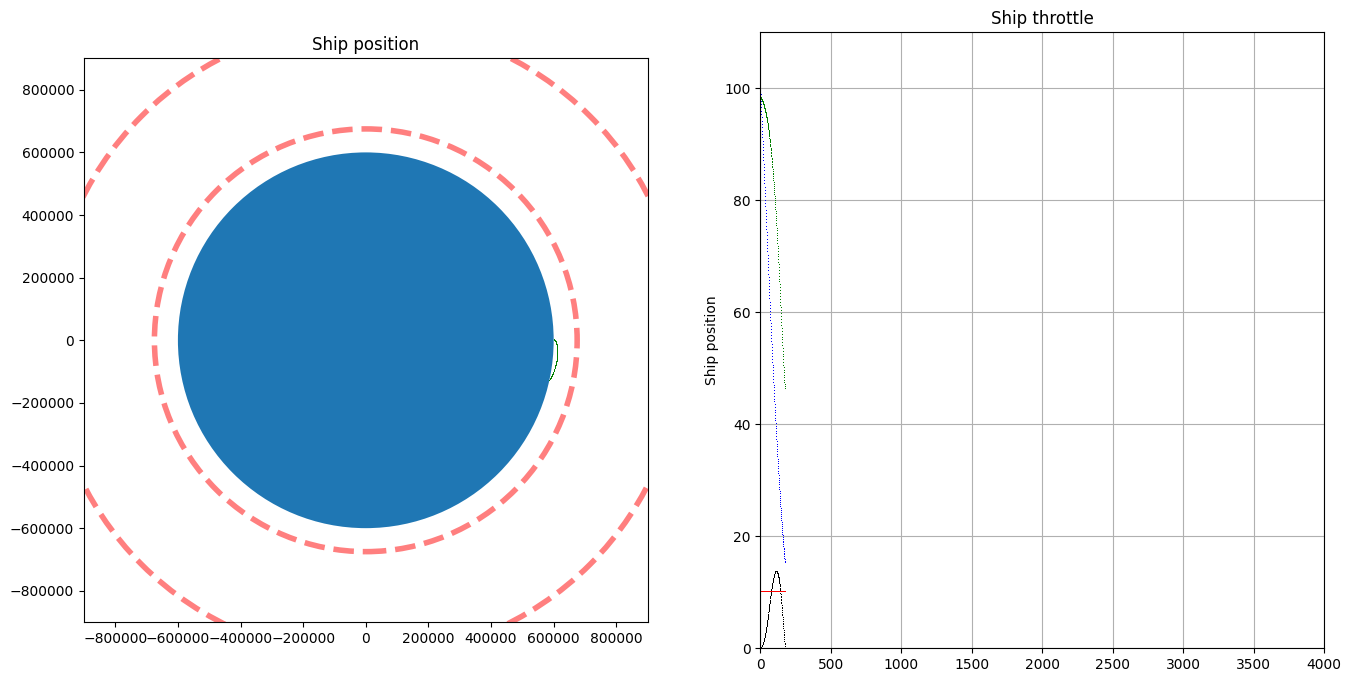


EPOCH: 12/1000, mean rewards: -249998.2538
DISCOUNTING AND NORMALIZING REWARDS


Epoch 12 INIT
INIT Kerbin position: [0. 0.]
Running episode 0
INIT Kerbin position: [0. 0.]
First altitude: 600009.4126224518
First observation: [1.25501633e-04 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.98612946 0.9854534 ]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       9, rewards:   0.00, throttle: 98.6, angle: -0.00, fuel: 336000.0 LOSS: 4766.0263671875 
Time:  25, altitude:    1271, rewards:   0.25, throttle: 96.8, angle: -0.42, fuel: 286162.1 LOSS: 4596.5537109375 
Time:  50, altitude:    4926, rewards:   0.50, throttle: 93.8, angle: -0.81, fuel: 237479.6 LOSS: 4315.35205078125 
Time:  75, altitude:    9657, rewards:   0.75, throttle: 88.8, angle: -1.17, fuel: 190826.5 LOSS: 3861.

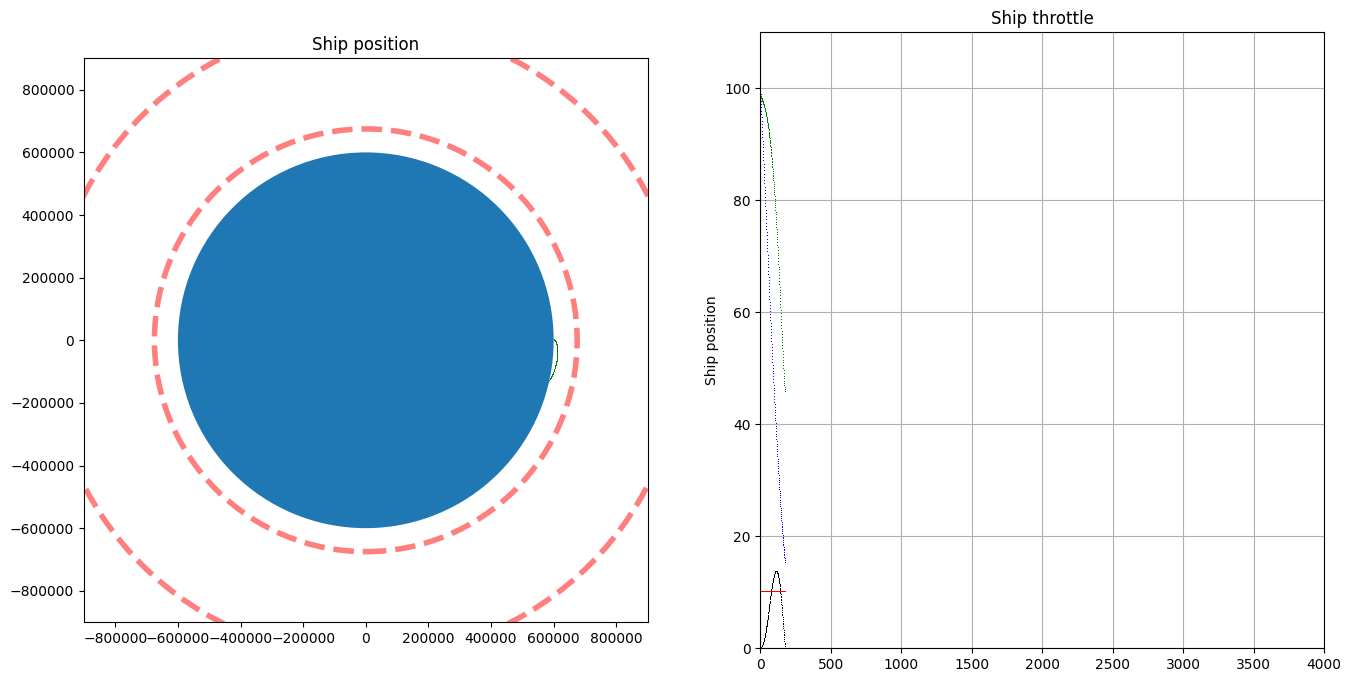

Running episode 1
INIT Kerbin position: [0. 0.]
First altitude: 600004.9950957298
First observation: [6.66012764e-05 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.98612857 0.98545253]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       5, rewards:   0.00, throttle: 98.6, angle: -0.00, fuel: 336000.0 LOSS: 4766.017578125 
Time:  25, altitude:    1267, rewards:   0.25, throttle: 96.8, angle: -0.42, fuel: 286162.1 LOSS: 4596.53515625 
Time:  50, altitude:    4921, rewards:   0.50, throttle: 93.8, angle: -0.81, fuel: 237479.8 LOSS: 4315.31494140625 
Time:  75, altitude:    9651, rewards:   0.75, throttle: 88.8, angle: -1.17, fuel: 190827.0 LOSS: 3860.966064453125 
Time: 100, altitude:   13136, rewards:   1.00, throttle: 80.9, angle: -1.48, fuel: 147445.9 LOSS: 3207.173583984375

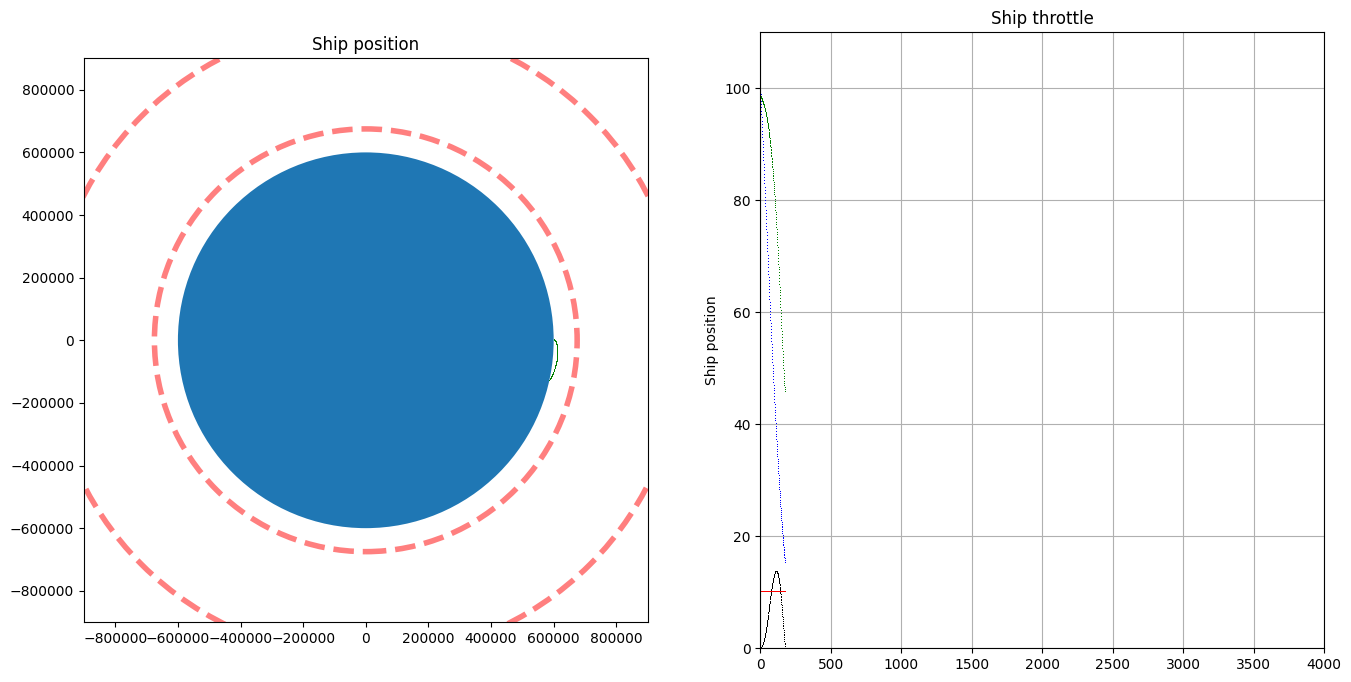


EPOCH: 13/1000, mean rewards: -249998.2529
DISCOUNTING AND NORMALIZING REWARDS


Epoch 13 INIT
INIT Kerbin position: [0. 0.]
Running episode 0
INIT Kerbin position: [0. 0.]
First altitude: 600006.6075992584
First observation: [8.81013234e-05 0.00000000e+00 7.42085890e-02 9.06993865e-02
 4.07500000e+00 1.25000000e-01]
First prediction: [[0.98669916 0.98603994]]
Expected throttle noise level: 0.0
Expected altitude noise level: 10
Expected crash penalty: -4.0
Expected discount value: 0.99966
Simulate flight INIT
WARNING! detected an epsilon norm!
Time:   0, altitude:       7, rewards:   0.00, throttle: 98.7, angle: -0.00, fuel: 336000.0 LOSS: 4771.533203125 


In [ ]:
import os
# Garbage Collector - use it like gc.collect()
import gc
gc.collect()

# T.4 E.36 => longest trajectory so far
# T8E1 - nice traj,
training = 12
n_epochs = 1000
n_episodes_per_epoch = 2
n_max_steps = 2500
discount_factor = 0.999966  # 20386 steps for 50% weight = 203.86s
# discount_factor = 0.9999  # 6931 steps for 50% weight = 69.31s
# USED FROM T01.E027 until T04.E036 max result 159...
# discount_factor = 0.99966  # 2038 steps for 50% weight = 20.38s
# discount_factor = 0.999  # 693 steps for 50% weight = 6.93s
# USED FROM START UNTIL TRAINING T01.E027 max result 69.0654
# discount_factor = 0.9966  # 204 steps for 50% weight = 2.04s
# discount_factor = 0.99  # 69 steps for 50% weight
model_started = True
load = True
load_checkpoint_folder = f"{drive_path}/training_{(training-1):02d}"
save_checkpoint_folder = f"{drive_path}/training_{training:02d}"

# To help out in initializing the model
if load:
    if model_started:
        # checkpoint_folder = f"{drive_path}/training_{(training-1):02d}"
        checkpoint_path = f"./{load_checkpoint_folder}/cp-0014.ckpt"
        checkpoint_dir = os.path.dirname(checkpoint_path)
        model.load_weights(checkpoint_path)
    else:
        training = 1
        n_epochs = 1
        n_episodes_per_epoch = 1

for epoch in range(n_epochs):
    last_epoch_mean_rewards = 1.0e-2
    last_epoch_max_time = 1.0e-2
    print(f"\n\nEpoch {epoch} INIT")

    checkpoint_path = f"./{save_checkpoint_folder}/cp-{epoch:04d}.ckpt"
    pictures_path = f"./{save_checkpoint_folder}/pictures/"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    pictures_dir = os.path.dirname(pictures_path)
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(pictures_dir, exist_ok=True)

    all_rewards, all_grads, last_epoch_max_time = run_multiple_episodes(
        n_episodes=n_episodes_per_epoch,
        n_max_steps=n_max_steps,
        model=model,
        loss_fn=loss_fn,
        epoch=epoch,
        last_epoch_mean_rewards=last_epoch_mean_rewards,
        last_epoch_max_t=last_epoch_max_time,
        checkpoint_folder=pictures_dir
    )

    # extra code – displays some debug info during training
    total_rewards = sum(map(sum, all_rewards))
    print(f"\nEPOCH: {epoch + 1}/{n_epochs},"
          f" mean rewards: {total_rewards / n_episodes_per_epoch:.4f}")

    last_epoch_mean_rewards = total_rewards / n_episodes_per_epoch
    all_final_rewards = discount_and_normalize_rewards(
        all_rewards, discount_function(last_epoch_max_time)
    )
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

    model.save_weights(checkpoint_path.format(epoch=epoch))

    # trying to free up memory
    del all_rewards
    del all_grads
    del all_mean_grads
    del total_rewards
    del last_epoch_mean_rewards
    del last_epoch_max_time
    gc.collect()

if load and not model_started:
    checkpoint_path = "./training/cp-0150.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    model.load_weights(checkpoint_path)

In [ ]:
(600.0e+3 + float(tf.random.uniform([1, 1], 0.0, 1.0)[0][0] * 10.0e+3)) * np.array([1.0, 0.0])

In [ ]:
target_alt_m = 75000
for alt_m in range(0, 300000, 1000):
    if 0 < alt_m < 150e+3:
        altitude_reward = pow((target_alt_m - abs(alt_m - target_alt_m)) / target_alt_m, 6)
    else:
        altitude_reward = 0.0
    print(f"alt, rew: {alt_m/1000:5.0f} : {altitude_reward:2.3f}")

# velocity_reward = pow((self.target_orbital_vel_mps - abs(self.ship.velocity_r_fi_mps[1] - self.target_orbital_vel_mps)) / self.target_orbital_vel_mps, 2) * vel_rew_w
# fuel_reward = pow(self.ship.total_fuel_mass_kg / self.ship.initial_fuel_mass_kg, 2) * fuel_rew_w

In [ ]:
target_orbital_vel_mps = 2300
for velocity_r_fi_mps in range(0, 4000, 50):
    velocity_reward = pow((target_orbital_vel_mps - abs(velocity_r_fi_mps - target_orbital_vel_mps)) / target_orbital_vel_mps, 12)
    print(f"alt, rew: {velocity_r_fi_mps:4.0f} : {velocity_reward:2.3f}")